In [3]:
from __future__ import division
import utils
import pandas as pd
import numpy as np
import math
import datetime as dt

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.feature_selection import VarianceThreshold
# from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, f1_score, confusion_matrix, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
# import lightgbm as lgb

from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
# from sklearn import preprocessing

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

pd.options.display.float_format = "{:.2f}".format
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
# np.set_printoptions(threshold=np.nan)  

#####################################################################################

def stratify_sampling(df, tot_out_rows, strat_col):
    rowspercol=round(tot_out_rows/df[strat_col].nunique())
    a=pd.DataFrame()
    
    for strata in range(0,df[strat_col].nunique()):
        print(strata)
        a=a.append(df[df[strat_col]==strata].sample(rowspercol))
        print (a.shape)
    return a.sample(tot_out_rows)

ModuleNotFoundError: No module named 'seaborn'

# Read dataset

In [157]:
df=pd.read_pickle('/home/gjain/df_cat_enc_part1.pkl')

In [97]:
df.isnull().sum()

timestamp                       0
order_number                    0
pay_id                          0
affiliate                       0
channelcode                     0
local_trans_amt                 0
trans_currency                  0
nonmor                          0
payment_method                  0
eci                             0
card_cvvmatch                   0
card_avsmatch                   0
customer_title                  0
website_language                0
brand_continent                 0
HasTicketInsurance              0
HasInsurance                    0
HasBaggage                      0
HasBaggage_Sale                 0
HasAirhelpPlus                  0
UsedVoucher                     0
HasSP                           0
gender                          0
BookerCity                      0
BookerCountry_Name              0
TotalAmountEUR                  0
airline                         0
Consolidator                    0
OriginAirportCode               0
OriginCityName

In [158]:
df.target.value_counts()

0    1386632
1    2570   
Name: target, dtype: int64

In [159]:
#target, timestamp, order_number, pay_id not included below
#72 cols
all_cols=['affiliate','channelcode',
       'local_trans_amt', 'trans_currency', 'nonmor', 'payment_method', 'eci',
       'card_cvvmatch', 'card_avsmatch', 'customer_title', 'website_language',
       'brand_continent', 'HasTicketInsurance', 'HasInsurance', 'HasBaggage',
       'HasBaggage_Sale', 'HasAirhelpPlus', 'UsedVoucher', 'HasSP', 'gender',
       'BookerCity', 'BookerCountry_Name', 'TotalAmountEUR', 'airline',
       'Consolidator', 'OriginAirportCode', 'OriginCityName',
       'OriginCountryName', 'OriginWorldPartName', 'OriginRegion',
       'OriginSubRegion', 'DestinationAirportCode', 'DestinationCityName',
       'DestinationCountryName', 'DestinationWorldPartName',
       'DestinationRegion', 'DestinationSubRegion', 'Supplier',
       'DomesticOrInternational', 'Haul', 'OneWayOrReturn', 'IsCombinedOneWay',
       'IsITFare', 'TotalNumberOfPassengers', 'TotalNumberOfAdults',
       'TotalNumberOfChildren', 'TotalNumberOfInfants', 'COW_NumberOfSegments',
       'COW_NumberOfInboundSegments', 'COW_NumberOfOutboundSegments',
       'NumberOfTickets', 'FareBaseAmount', 'HasSplitPnr', 'DeviceType',
#        'OrderDateBrandTime_Month',
        'IsLowCost', 'email_user_id_len',
       'email_domain', 'dob_month', 'bookerIsTravelAgency',
       'successful_attempt_no', 'country_ip_flight_MatchScore',
       'flight_distance', 'days_to_departure', 'vacation_length',
       'cities_in_itinerary', 'cabin_class', 'name_len', 'weekend_booking',
       'booking_daytime', 'bookerAgeBracket', 'email_sanity_score',
          #new ad
         'OrderDateBrandTime_DayOfWeek',
         'ordermonth_sin','ordermonth_cos','departuremonth_sin','departuremonth_cos']

all_cat_cols=['affiliate','channelcode','trans_currency','nonmor','payment_method','eci','card_cvvmatch','card_avsmatch',
              'customer_title','website_language','brand_continent','HasTicketInsurance','HasInsurance','HasBaggage',
              'HasBaggage_Sale','HasAirhelpPlus','UsedVoucher','HasSP','gender','BookerCity','BookerCountry_Name','airline',
              'Consolidator','OriginAirportCode','OriginCityName','OriginCountryName','OriginWorldPartName','OriginRegion',
          'OriginSubRegion','DestinationAirportCode','DestinationCityName','DestinationCountryName','DestinationWorldPartName',
              'DestinationRegion','DestinationSubRegion','Supplier','DomesticOrInternational','Haul','OneWayOrReturn',
              'IsCombinedOneWay','IsITFare','HasSplitPnr','DeviceType','IsLowCost','email_domain','cabin_class',
              'bookerIsTravelAgency','weekend_booking','dob_month','booking_daytime', 'bookerAgeBracket',
          'OrderDateBrandTime_DayOfWeek']

#Get location of loo_cols, our categorical columns, in df[all_cols], to feed in Pool
df2=df[all_cols]
categorical_features_pos=[df2.columns.get_loc(c) for c in all_cat_cols]
categorical_features_pos

[0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 52,
 53,
 54,
 56,
 65,
 58,
 67,
 57,
 68,
 69,
 71]

# Random under-sampling

In [185]:
sampler = RandomUnderSampler({1: 2570, 0: 80000}, random_state=16)

X, y = sampler.fit_sample(df[all_cols], df.target)
X=pd.DataFrame(X, columns=[all_cols])

# TomekLinks
sampler = TomekLinks(ratio={1: 2570, 0: 80000},random_state=0)
X, y = sampler.fit_sample(df[all_cols], df.target)
X=pd.DataFrame(X, columns=[all_cols])

In [186]:
from imblearn.over_sampling import RandomOverSampler, SMOTENC
osampler=SMOTENC(categorical_features_pos, {1: 80000, 0: 80000}, random_state=16)
X1, y = osampler.fit_resample(X, y)
X=pd.DataFrame(X1, columns=[all_cols])
X.shape

(160000, 76)

# GMM sampling

In [16]:
gmm_data=df[all_cols][df.target==0].copy()

#############################################################################
#############################################################################
scaler = StandardScaler()
gmm_data_arr=scaler.fit_transform(gmm_data)

classifier = GaussianMixture(n_components=5,covariance_type='full', random_state=50,n_init=1, verbose=1,max_iter=100)
classifier.fit(gmm_data_arr)
ll = classifier.score(gmm_data_arr)
print (ll)

gmm_data['cluster']=classifier.predict(gmm_data_arr)
del gmm_data_arr
sampled_good_bookings=utils.stratify_sampling(gmm_data, 50000, 'cluster')
#############################################################################
#############################################################################

gmm_data=df[all_cols][df.target==1].copy()
gmm_data['target']=1
sampled_good_bookings.drop(['cluster'],axis=1,inplace=True)
sampled_good_bookings['target']=0
sampled_data=gmm_data.append(sampled_good_bookings)

del gmm_data
del sampled_good_bookings

train=sampled_data.iloc[:,:-1]
target=sampled_data.iloc[:,-1]

del sampled_data

train.to_csv('/home/gjain/train.csv')
target.to_csv('/home/gjain/target.csv')

# train=pd.read_csv('/home/gjain/train.csv')
# target=pd.read_csv('/home/gjain/target.csv')

/root/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/root/.local/lib/python3.5/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# No sampling

In [127]:
y=df.target
X=df[all_cols]

In [293]:
train=X.as_matrix()
target=np.array(y)

valid=pd.read_pickle('/home/gjain/dec_data.pkl')
X_valid=valid[all_cols].as_matrix()
y_valid=np.array(valid.target)

test=pd.read_pickle('/home/gjain/jan_test_data.pkl')
X_test=test[all_cols].as_matrix()
y_test=np.array(test.target)

print (X.shape)
print (X_valid.shape)
print (X_test.shape)

/home/ubuntu/yes/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/ubuntu/yes/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/ubuntu/yes/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


(160000, 76)
(267688, 76)
(294513, 76)


In [298]:
space ={
        'max_depth': hp.choice('max_depth',range(3,10)),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'n_estimators': 4000, #to be decided by early stopping
        'subsample': hp.uniform('subsample', 0.3, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
        'min_child_samples': hp.choice('min_child_samples',range(5,2000)),
        'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
        'scale_pos_weight': hp.quniform('scale_pos_weight', 15, 1000, 1)
       }

#     'class_weight': hp.choice('class_weight', [None, 'balanced']),  

def get_lgb_params(space):
    lgb_params = dict()
    lgb_params['boosting_type'] = 'gbdt'
    lgb_params['objective'] = 'binary'
    lgb_params['max_depth'] = -1
    lgb_params['learning_rate'] = space['learning_rate']
    lgb_params['n_estimators'] = space['n_estimators']
    lgb_params['subsample'] = space['subsample']
#     lgb_params['class_weight'] = {0:1, 1:18}
    lgb_params['colsample_bytree'] = space['colsample_bytree']
    lgb_params['reg_alpha'] = space['reg_alpha'] 
    lgb_params['reg_lambda'] = space['reg_lambda'] 
    lgb_params['random_state'] = 33
    lgb_params['min_child_samples'] = space['min_child_samples']
    lgb_params['importance_type'] = 'gain'
    lgb_params['num_leaves'] = int(space['num_leaves'])
    lgb_params['scale_pos_weight'] = int(space['scale_pos_weight'])    
    return lgb_params


def acc_model(space):
    
    params=get_lgb_params(space)
    
    clf = LGBMClassifier(**params)
    
    fit_params={'eval_set':[(X_valid,y_valid)],
            'eval_metric':'f1_score', 
            'early_stopping_rounds':40,
            'verbose':True,
            'categorical_feature':categorical_features_pos}
    
    return cross_val_score(clf, train, target, scoring='f1', cv=5, fit_params=fit_params).mean()

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=10, trials=trials)
print ('best:')
print (best)


  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.674696              
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's binary_logloss: 0.663094              
[3]	valid_0's binary_logloss: 0.646487              
[4]	valid_0's binary_logloss: 0.630682              
[5]	valid_0's binary_logloss: 0.617275              
[6]	valid_0's binary_logloss: 0.604391              
[7]	valid_0's binary_logloss: 0.592542              
[8]	valid_0's binary_logloss: 0.584798              
[9]	valid_0's binary_logloss: 0.571361              
[10]	valid_0's binary_logloss: 0.562502             
[11]	valid_0's binary_logloss: 0.553931             
[12]	valid_0's binary_logloss: 0.545362             
[13]	valid_0's binary_logloss: 0.538686             
[14]	valid_0's binary_logloss: 0.532084             
[15]	valid_0's binary_logloss: 0.521562             
[16]	valid_0's binary_logloss: 0.518598             
[17]	valid_0's binary_logloss: 0.51174              
[18]	valid_0's binary_logloss: 0.5064

[308]	valid_0's binary_logloss: 0.0397873           
[309]	valid_0's binary_logloss: 0.0392776           
[310]	valid_0's binary_logloss: 0.0388473           
[311]	valid_0's binary_logloss: 0.0384888           
[312]	valid_0's binary_logloss: 0.0381256           
[313]	valid_0's binary_logloss: 0.0377396           
[314]	valid_0's binary_logloss: 0.0373968           
[315]	valid_0's binary_logloss: 0.0370468           
[316]	valid_0's binary_logloss: 0.0365482           
[317]	valid_0's binary_logloss: 0.0362524           
[318]	valid_0's binary_logloss: 0.0358805           
[319]	valid_0's binary_logloss: 0.0356218           
[320]	valid_0's binary_logloss: 0.0352698           
[321]	valid_0's binary_logloss: 0.0351116           
[322]	valid_0's binary_logloss: 0.0347665           
[323]	valid_0's binary_logloss: 0.0344359           
[324]	valid_0's binary_logloss: 0.0341606           
[325]	valid_0's binary_logloss: 0.0337651           
[326]	valid_0's binary_logloss: 0.0336391     

[616]	valid_0's binary_logloss: 0.0136056           
[617]	valid_0's binary_logloss: 0.013568            
[618]	valid_0's binary_logloss: 0.013523            
[619]	valid_0's binary_logloss: 0.0135155           
[620]	valid_0's binary_logloss: 0.0135106           
[621]	valid_0's binary_logloss: 0.0135511           
[622]	valid_0's binary_logloss: 0.0135419           
[623]	valid_0's binary_logloss: 0.0135146           
[624]	valid_0's binary_logloss: 0.0135564           
[625]	valid_0's binary_logloss: 0.0135429           
[626]	valid_0's binary_logloss: 0.0135628           
[627]	valid_0's binary_logloss: 0.0135538           
[628]	valid_0's binary_logloss: 0.0135578           
[629]	valid_0's binary_logloss: 0.0135399           
[630]	valid_0's binary_logloss: 0.0135373           
[631]	valid_0's binary_logloss: 0.0135282           
[632]	valid_0's binary_logloss: 0.0135144           
[633]	valid_0's binary_logloss: 0.013511            
[634]	valid_0's binary_logloss: 0.0135179     

[924]	valid_0's binary_logloss: 0.0122686           
[925]	valid_0's binary_logloss: 0.0122713           
[926]	valid_0's binary_logloss: 0.0122731           
[927]	valid_0's binary_logloss: 0.0122707           
[928]	valid_0's binary_logloss: 0.0122704           
[929]	valid_0's binary_logloss: 0.0122694           
[930]	valid_0's binary_logloss: 0.01226             
[931]	valid_0's binary_logloss: 0.0122609           
[932]	valid_0's binary_logloss: 0.012261            
[933]	valid_0's binary_logloss: 0.0122564           
[934]	valid_0's binary_logloss: 0.0122511           
[935]	valid_0's binary_logloss: 0.0122477           
[936]	valid_0's binary_logloss: 0.0122325           
[937]	valid_0's binary_logloss: 0.0122249           
[938]	valid_0's binary_logloss: 0.0122233           
[939]	valid_0's binary_logloss: 0.0122108           
[940]	valid_0's binary_logloss: 0.0122083           
[941]	valid_0's binary_logloss: 0.0122009           
[942]	valid_0's binary_logloss: 0.0121955     

[1232]	valid_0's binary_logloss: 0.0118003          
[1233]	valid_0's binary_logloss: 0.0118002          
[1234]	valid_0's binary_logloss: 0.0117981          
[1235]	valid_0's binary_logloss: 0.0117975          
[1236]	valid_0's binary_logloss: 0.0117954          
[1237]	valid_0's binary_logloss: 0.0117957          
[1238]	valid_0's binary_logloss: 0.0117929          
[1239]	valid_0's binary_logloss: 0.0117922          
[1240]	valid_0's binary_logloss: 0.0117923          
[1241]	valid_0's binary_logloss: 0.0117944          
[1242]	valid_0's binary_logloss: 0.0117935          
[1243]	valid_0's binary_logloss: 0.0117926          
[1244]	valid_0's binary_logloss: 0.0117909          
[1245]	valid_0's binary_logloss: 0.0117861          
[1246]	valid_0's binary_logloss: 0.0117854          
[1247]	valid_0's binary_logloss: 0.0117847          
[1248]	valid_0's binary_logloss: 0.0117855          
[1249]	valid_0's binary_logloss: 0.0117835          
[1250]	valid_0's binary_logloss: 0.0117798    

[1540]	valid_0's binary_logloss: 0.01159            
[1541]	valid_0's binary_logloss: 0.0115904          
[1542]	valid_0's binary_logloss: 0.0115896          
[1543]	valid_0's binary_logloss: 0.0115931          
[1544]	valid_0's binary_logloss: 0.0115912          
[1545]	valid_0's binary_logloss: 0.0115914          
[1546]	valid_0's binary_logloss: 0.0115917          
[1547]	valid_0's binary_logloss: 0.0115905          
[1548]	valid_0's binary_logloss: 0.0115923          
[1549]	valid_0's binary_logloss: 0.0115918          
[1550]	valid_0's binary_logloss: 0.0115924          
[1551]	valid_0's binary_logloss: 0.0115912          
[1552]	valid_0's binary_logloss: 0.0115924          
[1553]	valid_0's binary_logloss: 0.0115925          
[1554]	valid_0's binary_logloss: 0.0115909          
[1555]	valid_0's binary_logloss: 0.0115906          
[1556]	valid_0's binary_logloss: 0.0115902          
[1557]	valid_0's binary_logloss: 0.0115885          
[1558]	valid_0's binary_logloss: 0.0115889    

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.687389              
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's binary_logloss: 0.687982              
[3]	valid_0's binary_logloss: 0.683874              
[4]	valid_0's binary_logloss: 0.680683              
[5]	valid_0's binary_logloss: 0.678298              
[6]	valid_0's binary_logloss: 0.677291              
[7]	valid_0's binary_logloss: 0.675816              
[8]	valid_0's binary_logloss: 0.67916               
[9]	valid_0's binary_logloss: 0.677171              
[10]	valid_0's binary_logloss: 0.681348             
[11]	valid_0's binary_logloss: 0.682062             
[12]	valid_0's binary_logloss: 0.682472             
[13]	valid_0's binary_logloss: 0.683517             
[14]	valid_0's binary_logloss: 0.683916             
[15]	valid_0's binary_logloss: 0.684451             
[16]	valid_0's binary_logloss: 0.689132             
[17]	valid_0's binary_logloss: 0.690845             
[18]	valid_0's binary_logloss: 0.6929

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.687597              
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's binary_logloss: 0.687835              
[3]	valid_0's binary_logloss: 0.683818              
[4]	valid_0's binary_logloss: 0.680622              
[5]	valid_0's binary_logloss: 0.6781                
[6]	valid_0's binary_logloss: 0.677068              
[7]	valid_0's binary_logloss: 0.674822              
[8]	valid_0's binary_logloss: 0.676851              
[9]	valid_0's binary_logloss: 0.675261              
[10]	valid_0's binary_logloss: 0.678717             
[11]	valid_0's binary_logloss: 0.679281             
[12]	valid_0's binary_logloss: 0.679277             
[13]	valid_0's binary_logloss: 0.679024             
[14]	valid_0's binary_logloss: 0.679031             
[15]	valid_0's binary_logloss: 0.67938              
[16]	valid_0's binary_logloss: 0.6823               
[17]	valid_0's binary_logloss: 0.683495             
[18]	valid_0's binary_logloss: 0.6863

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.687327              
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's binary_logloss: 0.686982              
[3]	valid_0's binary_logloss: 0.682919              
[4]	valid_0's binary_logloss: 0.679781              
[5]	valid_0's binary_logloss: 0.676963              
[6]	valid_0's binary_logloss: 0.675589              
[7]	valid_0's binary_logloss: 0.67427               
[8]	valid_0's binary_logloss: 0.676377              
[9]	valid_0's binary_logloss: 0.675571              
[10]	valid_0's binary_logloss: 0.678194             
[11]	valid_0's binary_logloss: 0.678601             
[12]	valid_0's binary_logloss: 0.678567             
[13]	valid_0's binary_logloss: 0.679489             
[14]	valid_0's binary_logloss: 0.68057              
[15]	valid_0's binary_logloss: 0.680932             
[16]	valid_0's binary_logloss: 0.685191             
[17]	valid_0's binary_logloss: 0.687588             
[18]	valid_0's binary_logloss: 0.6884

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.687341              
Training until validation scores don't improve for 40 rounds.
[2]	valid_0's binary_logloss: 0.68588               
[3]	valid_0's binary_logloss: 0.682094              
[4]	valid_0's binary_logloss: 0.679022              
[5]	valid_0's binary_logloss: 0.676595              
[6]	valid_0's binary_logloss: 0.675591              
[7]	valid_0's binary_logloss: 0.674479              
[8]	valid_0's binary_logloss: 0.676622              
[9]	valid_0's binary_logloss: 0.675536              
[10]	valid_0's binary_logloss: 0.678656             
[11]	valid_0's binary_logloss: 0.679442             
[12]	valid_0's binary_logloss: 0.67877              
[13]	valid_0's binary_logloss: 0.679284             
[14]	valid_0's binary_logloss: 0.680588             
[15]	valid_0's binary_logloss: 0.681198             
[16]	valid_0's binary_logloss: 0.685253             
[17]	valid_0's binary_logloss: 0.68666              
[18]	valid_0's binary_logloss: 0.6891

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.685815                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.685759                                        
[3]	valid_0's binary_logloss: 0.680365                                        
[4]	valid_0's binary_logloss: 0.674503                                        
[5]	valid_0's binary_logloss: 0.668309                                        
[6]	valid_0's binary_logloss: 0.666316                                        
[7]	valid_0's binary_logloss: 0.659706                                        
[8]	valid_0's binary_logloss: 0.656269                                        
[9]	valid_0's binary_logloss: 0.654205                                        
[10]	valid_0's binary_logloss: 0.65028                                        
[11]	valid_0's binary_logloss: 0.64464                                        
[12]	valid_0's binary_logloss: 0.640766             

[206]	valid_0's binary_logloss: 0.326049                                      
[207]	valid_0's binary_logloss: 0.323847                                      
[208]	valid_0's binary_logloss: 0.32357                                       
[209]	valid_0's binary_logloss: 0.321607                                      
[210]	valid_0's binary_logloss: 0.319163                                      
[211]	valid_0's binary_logloss: 0.317493                                      
[212]	valid_0's binary_logloss: 0.318322                                      
[213]	valid_0's binary_logloss: 0.316137                                      
[214]	valid_0's binary_logloss: 0.315207                                      
[215]	valid_0's binary_logloss: 0.313926                                      
[216]	valid_0's binary_logloss: 0.314058                                      
[217]	valid_0's binary_logloss: 0.31302                                       
[218]	valid_0's binary_logloss: 0.311466            

[412]	valid_0's binary_logloss: 0.13434                                       
[413]	valid_0's binary_logloss: 0.133868                                      
[414]	valid_0's binary_logloss: 0.132786                                      
[415]	valid_0's binary_logloss: 0.131483                                      
[416]	valid_0's binary_logloss: 0.129834                                      
[417]	valid_0's binary_logloss: 0.129229                                      
[418]	valid_0's binary_logloss: 0.12884                                       
[419]	valid_0's binary_logloss: 0.128269                                      
[420]	valid_0's binary_logloss: 0.127324                                      
[421]	valid_0's binary_logloss: 0.12689                                       
[422]	valid_0's binary_logloss: 0.126529                                      
[423]	valid_0's binary_logloss: 0.125945                                      
[424]	valid_0's binary_logloss: 0.125483            

[618]	valid_0's binary_logloss: 0.0520509                                     
[619]	valid_0's binary_logloss: 0.0519936                                     
[620]	valid_0's binary_logloss: 0.051804                                      
[621]	valid_0's binary_logloss: 0.0515939                                     
[622]	valid_0's binary_logloss: 0.0519859                                     
[623]	valid_0's binary_logloss: 0.0516805                                     
[624]	valid_0's binary_logloss: 0.0513926                                     
[625]	valid_0's binary_logloss: 0.0512733                                     
[626]	valid_0's binary_logloss: 0.0509336                                     
[627]	valid_0's binary_logloss: 0.0512362                                     
[628]	valid_0's binary_logloss: 0.0509761                                     
[629]	valid_0's binary_logloss: 0.0507454                                     
[630]	valid_0's binary_logloss: 0.0505073           

[824]	valid_0's binary_logloss: 0.0266484                                     
[825]	valid_0's binary_logloss: 0.0265553                                     
[826]	valid_0's binary_logloss: 0.0264037                                     
[827]	valid_0's binary_logloss: 0.0265495                                     
[828]	valid_0's binary_logloss: 0.0264509                                     
[829]	valid_0's binary_logloss: 0.0263846                                     
[830]	valid_0's binary_logloss: 0.0262978                                     
[831]	valid_0's binary_logloss: 0.0262244                                     
[832]	valid_0's binary_logloss: 0.0261298                                     
[833]	valid_0's binary_logloss: 0.0260725                                     
[834]	valid_0's binary_logloss: 0.0259644                                     
[835]	valid_0's binary_logloss: 0.0258632                                     
[836]	valid_0's binary_logloss: 0.0257625           

[1030]	valid_0's binary_logloss: 0.0170846                                    
[1031]	valid_0's binary_logloss: 0.017049                                     
[1032]	valid_0's binary_logloss: 0.0170144                                    
[1033]	valid_0's binary_logloss: 0.0169791                                    
[1034]	valid_0's binary_logloss: 0.0169591                                    
[1035]	valid_0's binary_logloss: 0.0169323                                    
[1036]	valid_0's binary_logloss: 0.0170398                                    
[1037]	valid_0's binary_logloss: 0.0170158                                    
[1038]	valid_0's binary_logloss: 0.0169808                                    
[1039]	valid_0's binary_logloss: 0.0169626                                    
[1040]	valid_0's binary_logloss: 0.0169222                                    
[1041]	valid_0's binary_logloss: 0.016893                                     
[1042]	valid_0's binary_logloss: 0.0168562          

[1236]	valid_0's binary_logloss: 0.0135832                                    
[1237]	valid_0's binary_logloss: 0.0135401                                    
[1238]	valid_0's binary_logloss: 0.0135229                                    
[1239]	valid_0's binary_logloss: 0.0135462                                    
[1240]	valid_0's binary_logloss: 0.013536                                     
[1241]	valid_0's binary_logloss: 0.0135233                                    
[1242]	valid_0's binary_logloss: 0.0135102                                    
[1243]	valid_0's binary_logloss: 0.0135067                                    
[1244]	valid_0's binary_logloss: 0.013498                                     
[1245]	valid_0's binary_logloss: 0.0134947                                    
[1246]	valid_0's binary_logloss: 0.0134755                                    
[1247]	valid_0's binary_logloss: 0.0134658                                    
[1248]	valid_0's binary_logloss: 0.0134517          

[1442]	valid_0's binary_logloss: 0.0125874                                    
[1443]	valid_0's binary_logloss: 0.0125874                                    
[1444]	valid_0's binary_logloss: 0.0125793                                    
[1445]	valid_0's binary_logloss: 0.012573                                     
[1446]	valid_0's binary_logloss: 0.0125749                                    
[1447]	valid_0's binary_logloss: 0.0125677                                    
[1448]	valid_0's binary_logloss: 0.0125543                                    
[1449]	valid_0's binary_logloss: 0.0125554                                    
[1450]	valid_0's binary_logloss: 0.0125428                                    
[1451]	valid_0's binary_logloss: 0.0125365                                    
[1452]	valid_0's binary_logloss: 0.0125314                                    
[1453]	valid_0's binary_logloss: 0.0125323                                    
[1454]	valid_0's binary_logloss: 0.0125003          

[1648]	valid_0's binary_logloss: 0.0116658                                    
[1649]	valid_0's binary_logloss: 0.0116692                                    
[1650]	valid_0's binary_logloss: 0.0116675                                    
[1651]	valid_0's binary_logloss: 0.0116658                                    
[1652]	valid_0's binary_logloss: 0.0116582                                    
[1653]	valid_0's binary_logloss: 0.0116596                                    
[1654]	valid_0's binary_logloss: 0.0116524                                    
[1655]	valid_0's binary_logloss: 0.0116513                                    
[1656]	valid_0's binary_logloss: 0.0116307                                    
[1657]	valid_0's binary_logloss: 0.0116289                                    
[1658]	valid_0's binary_logloss: 0.0116236                                    
[1659]	valid_0's binary_logloss: 0.0116259                                    
[1660]	valid_0's binary_logloss: 0.0116208          

[1854]	valid_0's binary_logloss: 0.0110976                                    
[1855]	valid_0's binary_logloss: 0.0111156                                    
[1856]	valid_0's binary_logloss: 0.0111159                                    
[1857]	valid_0's binary_logloss: 0.0111143                                    
[1858]	valid_0's binary_logloss: 0.0111149                                    
[1859]	valid_0's binary_logloss: 0.0111121                                    
[1860]	valid_0's binary_logloss: 0.0111106                                    
[1861]	valid_0's binary_logloss: 0.0111124                                    
[1862]	valid_0's binary_logloss: 0.011111                                     
[1863]	valid_0's binary_logloss: 0.0111094                                    
[1864]	valid_0's binary_logloss: 0.0111069                                    
[1865]	valid_0's binary_logloss: 0.0111064                                    
[1866]	valid_0's binary_logloss: 0.0111057          

[2060]	valid_0's binary_logloss: 0.0107783                                    
[2061]	valid_0's binary_logloss: 0.0107754                                    
[2062]	valid_0's binary_logloss: 0.0107702                                    
[2063]	valid_0's binary_logloss: 0.010767                                     
[2064]	valid_0's binary_logloss: 0.0107658                                    
[2065]	valid_0's binary_logloss: 0.010766                                     
[2066]	valid_0's binary_logloss: 0.0107628                                    
[2067]	valid_0's binary_logloss: 0.0107642                                    
[2068]	valid_0's binary_logloss: 0.0107622                                    
[2069]	valid_0's binary_logloss: 0.0107567                                    
[2070]	valid_0's binary_logloss: 0.0107551                                    
[2071]	valid_0's binary_logloss: 0.010753                                     
[2072]	valid_0's binary_logloss: 0.010753           

[2266]	valid_0's binary_logloss: 0.0105568                                    
[2267]	valid_0's binary_logloss: 0.0105545                                    
[2268]	valid_0's binary_logloss: 0.0105531                                    
[2269]	valid_0's binary_logloss: 0.0105517                                    
[2270]	valid_0's binary_logloss: 0.0105473                                    
[2271]	valid_0's binary_logloss: 0.0105465                                    
[2272]	valid_0's binary_logloss: 0.0105431                                    
[2273]	valid_0's binary_logloss: 0.0105412                                    
[2274]	valid_0's binary_logloss: 0.0105403                                    
[2275]	valid_0's binary_logloss: 0.0105375                                    
[2276]	valid_0's binary_logloss: 0.010537                                     
[2277]	valid_0's binary_logloss: 0.0105387                                    
[2278]	valid_0's binary_logloss: 0.0105389          

[2472]	valid_0's binary_logloss: 0.0103647                                    
[2473]	valid_0's binary_logloss: 0.0103635                                    
[2474]	valid_0's binary_logloss: 0.0103597                                    
[2475]	valid_0's binary_logloss: 0.0103583                                    
[2476]	valid_0's binary_logloss: 0.0103562                                    
[2477]	valid_0's binary_logloss: 0.0103557                                    
[2478]	valid_0's binary_logloss: 0.0103568                                    
[2479]	valid_0's binary_logloss: 0.0103543                                    
[2480]	valid_0's binary_logloss: 0.0103557                                    
[2481]	valid_0's binary_logloss: 0.0103546                                    
[2482]	valid_0's binary_logloss: 0.0103542                                    
[2483]	valid_0's binary_logloss: 0.0103532                                    
[2484]	valid_0's binary_logloss: 0.0103536          

[2678]	valid_0's binary_logloss: 0.0102441                                    
[2679]	valid_0's binary_logloss: 0.0102434                                    
[2680]	valid_0's binary_logloss: 0.010244                                     
[2681]	valid_0's binary_logloss: 0.0102441                                    
[2682]	valid_0's binary_logloss: 0.0102418                                    
[2683]	valid_0's binary_logloss: 0.0102417                                    
[2684]	valid_0's binary_logloss: 0.0102428                                    
[2685]	valid_0's binary_logloss: 0.0102434                                    
[2686]	valid_0's binary_logloss: 0.0102432                                    
[2687]	valid_0's binary_logloss: 0.0102419                                    
[2688]	valid_0's binary_logloss: 0.0102433                                    
[2689]	valid_0's binary_logloss: 0.010242                                     
[2690]	valid_0's binary_logloss: 0.010242           

[2884]	valid_0's binary_logloss: 0.0101451                                    
[2885]	valid_0's binary_logloss: 0.0101441                                    
[2886]	valid_0's binary_logloss: 0.0101429                                    
[2887]	valid_0's binary_logloss: 0.0101443                                    
[2888]	valid_0's binary_logloss: 0.0101428                                    
[2889]	valid_0's binary_logloss: 0.0101431                                    
[2890]	valid_0's binary_logloss: 0.0101428                                    
[2891]	valid_0's binary_logloss: 0.0101422                                    
[2892]	valid_0's binary_logloss: 0.0101404                                    
[2893]	valid_0's binary_logloss: 0.0101386                                    
[2894]	valid_0's binary_logloss: 0.0101379                                    
[2895]	valid_0's binary_logloss: 0.0101381                                    
[2896]	valid_0's binary_logloss: 0.010138           

[3090]	valid_0's binary_logloss: 0.0100717                                    
[3091]	valid_0's binary_logloss: 0.0100712                                    
[3092]	valid_0's binary_logloss: 0.0100694                                    
[3093]	valid_0's binary_logloss: 0.0100713                                    
[3094]	valid_0's binary_logloss: 0.0100721                                    
[3095]	valid_0's binary_logloss: 0.0100703                                    
[3096]	valid_0's binary_logloss: 0.0100709                                    
[3097]	valid_0's binary_logloss: 0.0100721                                    
[3098]	valid_0's binary_logloss: 0.0100716                                    
[3099]	valid_0's binary_logloss: 0.0100702                                    
[3100]	valid_0's binary_logloss: 0.0100704                                    
[3101]	valid_0's binary_logloss: 0.0100713                                    
[3102]	valid_0's binary_logloss: 0.0100722          

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.690524                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.695717                                        
[3]	valid_0's binary_logloss: 0.694063                                        
[4]	valid_0's binary_logloss: 0.691584                                        
[5]	valid_0's binary_logloss: 0.691026                                        
[6]	valid_0's binary_logloss: 0.692749                                        
[7]	valid_0's binary_logloss: 0.69096                                         
[8]	valid_0's binary_logloss: 0.6904                                          
[9]	valid_0's binary_logloss: 0.69092                                         
[10]	valid_0's binary_logloss: 0.690675                                       
[11]	valid_0's binary_logloss: 0.688091                                       
[12]	valid_0's binary_logloss: 0.689392             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.6906                                          
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.695531                                        
[3]	valid_0's binary_logloss: 0.69377                                         
[4]	valid_0's binary_logloss: 0.691268                                        
[5]	valid_0's binary_logloss: 0.690659                                        
[6]	valid_0's binary_logloss: 0.692258                                        
[7]	valid_0's binary_logloss: 0.690555                                        
[8]	valid_0's binary_logloss: 0.690158                                        
[9]	valid_0's binary_logloss: 0.690848                                        
[10]	valid_0's binary_logloss: 0.690578                                       
[11]	valid_0's binary_logloss: 0.687989                                       
[12]	valid_0's binary_logloss: 0.689296             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.689879                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.695511                                        
[3]	valid_0's binary_logloss: 0.693537                                        
[4]	valid_0's binary_logloss: 0.691056                                        
[5]	valid_0's binary_logloss: 0.690374                                        
[6]	valid_0's binary_logloss: 0.691814                                        
[7]	valid_0's binary_logloss: 0.689947                                        
[8]	valid_0's binary_logloss: 0.689753                                        
[9]	valid_0's binary_logloss: 0.690506                                        
[10]	valid_0's binary_logloss: 0.690218                                       
[11]	valid_0's binary_logloss: 0.687581                                       
[12]	valid_0's binary_logloss: 0.688502             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.690611                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.695881                                        
[3]	valid_0's binary_logloss: 0.694123                                        
[4]	valid_0's binary_logloss: 0.691654                                        
[5]	valid_0's binary_logloss: 0.691194                                        
[6]	valid_0's binary_logloss: 0.69282                                         
[7]	valid_0's binary_logloss: 0.690928                                        
[8]	valid_0's binary_logloss: 0.690577                                        
[9]	valid_0's binary_logloss: 0.690965                                        
[10]	valid_0's binary_logloss: 0.690703                                       
[11]	valid_0's binary_logloss: 0.688003                                       
[12]	valid_0's binary_logloss: 0.689239             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.686113                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.68115                                         
[3]	valid_0's binary_logloss: 0.673853                                        
[4]	valid_0's binary_logloss: 0.666856                                        
[5]	valid_0's binary_logloss: 0.660144                                        
[6]	valid_0's binary_logloss: 0.653694                                        
[7]	valid_0's binary_logloss: 0.647172                                        
[8]	valid_0's binary_logloss: 0.643574                                        
[9]	valid_0's binary_logloss: 0.637699                                        
[10]	valid_0's binary_logloss: 0.631977                                       
[11]	valid_0's binary_logloss: 0.626332                                       
[12]	valid_0's binary_logloss: 0.621443             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.690675                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.691203                                        
[3]	valid_0's binary_logloss: 0.689193                                        
[4]	valid_0's binary_logloss: 0.687311                                        
[5]	valid_0's binary_logloss: 0.685479                                        
[6]	valid_0's binary_logloss: 0.684104                                        
[7]	valid_0's binary_logloss: 0.68249                                         
[8]	valid_0's binary_logloss: 0.682916                                        
[9]	valid_0's binary_logloss: 0.681591                                        
[10]	valid_0's binary_logloss: 0.680266                                       
[11]	valid_0's binary_logloss: 0.679356                                       
[12]	valid_0's binary_logloss: 0.678231             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.690761                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.691201                                        
[3]	valid_0's binary_logloss: 0.689171                                        
[4]	valid_0's binary_logloss: 0.687072                                        
[5]	valid_0's binary_logloss: 0.685187                                        
[6]	valid_0's binary_logloss: 0.68377                                         
[7]	valid_0's binary_logloss: 0.681968                                        
[8]	valid_0's binary_logloss: 0.682452                                        
[9]	valid_0's binary_logloss: 0.68093                                         
[10]	valid_0's binary_logloss: 0.679573                                       
[11]	valid_0's binary_logloss: 0.678486                                       
[12]	valid_0's binary_logloss: 0.677276             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.690648                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.690468                                        
[3]	valid_0's binary_logloss: 0.688531                                        
[4]	valid_0's binary_logloss: 0.686656                                        
[5]	valid_0's binary_logloss: 0.684766                                        
[6]	valid_0's binary_logloss: 0.68342                                         
[7]	valid_0's binary_logloss: 0.68184                                         
[8]	valid_0's binary_logloss: 0.682034                                        
[9]	valid_0's binary_logloss: 0.680944                                        
[10]	valid_0's binary_logloss: 0.679657                                       
[11]	valid_0's binary_logloss: 0.678665                                       
[12]	valid_0's binary_logloss: 0.677489             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.690697                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.690454                                        
[3]	valid_0's binary_logloss: 0.688459                                        
[4]	valid_0's binary_logloss: 0.68661                                         
[5]	valid_0's binary_logloss: 0.684736                                        
[6]	valid_0's binary_logloss: 0.683409                                        
[7]	valid_0's binary_logloss: 0.68186                                         
[8]	valid_0's binary_logloss: 0.682826                                        
[9]	valid_0's binary_logloss: 0.681494                                        
[10]	valid_0's binary_logloss: 0.680163                                       
[11]	valid_0's binary_logloss: 0.679145                                       
[12]	valid_0's binary_logloss: 0.677947             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.628597                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.590395                                        
[3]	valid_0's binary_logloss: 0.550731                                        
[4]	valid_0's binary_logloss: 0.51878                                         
[5]	valid_0's binary_logloss: 0.490702                                        
[6]	valid_0's binary_logloss: 0.468508                                        
[7]	valid_0's binary_logloss: 0.44714                                         
[8]	valid_0's binary_logloss: 0.426098                                        
[9]	valid_0's binary_logloss: 0.411228                                        
[10]	valid_0's binary_logloss: 0.399837                                       
[11]	valid_0's binary_logloss: 0.388675                                       
[12]	valid_0's binary_logloss: 0.37962              

[206]	valid_0's binary_logloss: 0.0134355                                     
[207]	valid_0's binary_logloss: 0.0134093                                     
[208]	valid_0's binary_logloss: 0.0133856                                     
[209]	valid_0's binary_logloss: 0.0133732                                     
[210]	valid_0's binary_logloss: 0.0133605                                     
[211]	valid_0's binary_logloss: 0.0133237                                     
[212]	valid_0's binary_logloss: 0.0132965                                     
[213]	valid_0's binary_logloss: 0.013277                                      
[214]	valid_0's binary_logloss: 0.0132571                                     
[215]	valid_0's binary_logloss: 0.013231                                      
[216]	valid_0's binary_logloss: 0.0132422                                     
[217]	valid_0's binary_logloss: 0.0132039                                     
[218]	valid_0's binary_logloss: 0.0131681           

[412]	valid_0's binary_logloss: 0.0118533                                     
[413]	valid_0's binary_logloss: 0.0118511                                     
[414]	valid_0's binary_logloss: 0.0118517                                     
[415]	valid_0's binary_logloss: 0.0118479                                     
[416]	valid_0's binary_logloss: 0.0118512                                     
[417]	valid_0's binary_logloss: 0.0118463                                     
[418]	valid_0's binary_logloss: 0.0118405                                     
[419]	valid_0's binary_logloss: 0.0118345                                     
[420]	valid_0's binary_logloss: 0.0118368                                     
[421]	valid_0's binary_logloss: 0.0118368                                     
[422]	valid_0's binary_logloss: 0.0118337                                     
[423]	valid_0's binary_logloss: 0.0118237                                     
[424]	valid_0's binary_logloss: 0.0118224           

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.666727                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.655736                                        
[3]	valid_0's binary_logloss: 0.637157                                        
[4]	valid_0's binary_logloss: 0.625892                                        
[5]	valid_0's binary_logloss: 0.617963                                        
[6]	valid_0's binary_logloss: 0.613959                                        
[7]	valid_0's binary_logloss: 0.612805                                        
[8]	valid_0's binary_logloss: 0.61374                                         
[9]	valid_0's binary_logloss: 0.616058                                        
[10]	valid_0's binary_logloss: 0.619741                                       
[11]	valid_0's binary_logloss: 0.625328                                       
[12]	valid_0's binary_logloss: 0.627769             

[206]	valid_0's binary_logloss: 0.098015                                      
[207]	valid_0's binary_logloss: 0.0977497                                     
[208]	valid_0's binary_logloss: 0.097572                                      
[209]	valid_0's binary_logloss: 0.0971593                                     
[210]	valid_0's binary_logloss: 0.0967113                                     
[211]	valid_0's binary_logloss: 0.0962344                                     
[212]	valid_0's binary_logloss: 0.0957516                                     
[213]	valid_0's binary_logloss: 0.0953872                                     
[214]	valid_0's binary_logloss: 0.0950534                                     
[215]	valid_0's binary_logloss: 0.0945082                                     
[216]	valid_0's binary_logloss: 0.0942241                                     
[217]	valid_0's binary_logloss: 0.093714                                      
[218]	valid_0's binary_logloss: 0.0932732           

[412]	valid_0's binary_logloss: 0.0652183                                     
[413]	valid_0's binary_logloss: 0.0649962                                     
[414]	valid_0's binary_logloss: 0.0648599                                     
[415]	valid_0's binary_logloss: 0.0647001                                     
[416]	valid_0's binary_logloss: 0.0646802                                     
[417]	valid_0's binary_logloss: 0.0645958                                     
[418]	valid_0's binary_logloss: 0.0644177                                     
[419]	valid_0's binary_logloss: 0.0643516                                     
[420]	valid_0's binary_logloss: 0.0659318                                     
[421]	valid_0's binary_logloss: 0.0658455                                     
[422]	valid_0's binary_logloss: 0.0658421                                     
[423]	valid_0's binary_logloss: 0.0658034                                     
[424]	valid_0's binary_logloss: 0.0657086           

[618]	valid_0's binary_logloss: 0.0571587                                     
[619]	valid_0's binary_logloss: 0.0570861                                     
[620]	valid_0's binary_logloss: 0.0571339                                     
[621]	valid_0's binary_logloss: 0.0570244                                     
[622]	valid_0's binary_logloss: 0.0570232                                     
[623]	valid_0's binary_logloss: 0.0569264                                     
[624]	valid_0's binary_logloss: 0.0569002                                     
[625]	valid_0's binary_logloss: 0.0569287                                     
[626]	valid_0's binary_logloss: 0.0570093                                     
[627]	valid_0's binary_logloss: 0.0569787                                     
[628]	valid_0's binary_logloss: 0.0569286                                     
[629]	valid_0's binary_logloss: 0.0568939                                     
[630]	valid_0's binary_logloss: 0.0569229           

[824]	valid_0's binary_logloss: 0.0531561                                     
[825]	valid_0's binary_logloss: 0.0532159                                     
[826]	valid_0's binary_logloss: 0.0532012                                     
[827]	valid_0's binary_logloss: 0.053188                                      
[828]	valid_0's binary_logloss: 0.0532425                                     
[829]	valid_0's binary_logloss: 0.0532425                                     
[830]	valid_0's binary_logloss: 0.0532425                                     
[831]	valid_0's binary_logloss: 0.0532425                                     
[832]	valid_0's binary_logloss: 0.0532425                                     
[833]	valid_0's binary_logloss: 0.0532425                                     
[834]	valid_0's binary_logloss: 0.0532425                                     
[835]	valid_0's binary_logloss: 0.0532425                                     
[836]	valid_0's binary_logloss: 0.0532425           

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.666417                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.656224                                        
[3]	valid_0's binary_logloss: 0.637711                                        
[4]	valid_0's binary_logloss: 0.62688                                         
[5]	valid_0's binary_logloss: 0.618149                                        
[6]	valid_0's binary_logloss: 0.612896                                        
[7]	valid_0's binary_logloss: 0.61153                                         
[8]	valid_0's binary_logloss: 0.613071                                        
[9]	valid_0's binary_logloss: 0.61532                                         
[10]	valid_0's binary_logloss: 0.614979                                       
[11]	valid_0's binary_logloss: 0.620178                                       
[12]	valid_0's binary_logloss: 0.621953             

[206]	valid_0's binary_logloss: 0.100243                                      
[207]	valid_0's binary_logloss: 0.099768                                      
[208]	valid_0's binary_logloss: 0.0993481                                     
[209]	valid_0's binary_logloss: 0.0987428                                     
[210]	valid_0's binary_logloss: 0.0981578                                     
[211]	valid_0's binary_logloss: 0.0972486                                     
[212]	valid_0's binary_logloss: 0.0967289                                     
[213]	valid_0's binary_logloss: 0.0961169                                     
[214]	valid_0's binary_logloss: 0.0957929                                     
[215]	valid_0's binary_logloss: 0.0953093                                     
[216]	valid_0's binary_logloss: 0.0946314                                     
[217]	valid_0's binary_logloss: 0.0940907                                     
[218]	valid_0's binary_logloss: 0.0935551           

[412]	valid_0's binary_logloss: 0.057899                                      
[413]	valid_0's binary_logloss: 0.057777                                      
[414]	valid_0's binary_logloss: 0.0576408                                     
[415]	valid_0's binary_logloss: 0.0575868                                     
[416]	valid_0's binary_logloss: 0.0575066                                     
[417]	valid_0's binary_logloss: 0.0574305                                     
[418]	valid_0's binary_logloss: 0.0571522                                     
[419]	valid_0's binary_logloss: 0.0571732                                     
[420]	valid_0's binary_logloss: 0.0571441                                     
[421]	valid_0's binary_logloss: 0.0570281                                     
[422]	valid_0's binary_logloss: 0.0569062                                     
[423]	valid_0's binary_logloss: 0.0568057                                     
[424]	valid_0's binary_logloss: 0.0566295           

[618]	valid_0's binary_logloss: 0.0499764                                     
[619]	valid_0's binary_logloss: 0.0499583                                     
[620]	valid_0's binary_logloss: 0.0498456                                     
[621]	valid_0's binary_logloss: 0.049825                                      
[622]	valid_0's binary_logloss: 0.0497596                                     
[623]	valid_0's binary_logloss: 0.0497178                                     
[624]	valid_0's binary_logloss: 0.0496602                                     
[625]	valid_0's binary_logloss: 0.0496482                                     
[626]	valid_0's binary_logloss: 0.049669                                      
[627]	valid_0's binary_logloss: 0.0495078                                     
[628]	valid_0's binary_logloss: 0.0495742                                     
[629]	valid_0's binary_logloss: 0.0494866                                     
[630]	valid_0's binary_logloss: 0.0494687           

[824]	valid_0's binary_logloss: 0.04675                                       
[825]	valid_0's binary_logloss: 0.04675                                       
[826]	valid_0's binary_logloss: 0.04675                                       
[827]	valid_0's binary_logloss: 0.04675                                       
[828]	valid_0's binary_logloss: 0.04675                                       
[829]	valid_0's binary_logloss: 0.04675                                       
[830]	valid_0's binary_logloss: 0.04675                                       
[831]	valid_0's binary_logloss: 0.04675                                       
[832]	valid_0's binary_logloss: 0.04675                                       
[833]	valid_0's binary_logloss: 0.04675                                       
[834]	valid_0's binary_logloss: 0.04675                                       
[835]	valid_0's binary_logloss: 0.04675                                       
[836]	valid_0's binary_logloss: 0.04675             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.666091                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.655819                                        
[3]	valid_0's binary_logloss: 0.637499                                        
[4]	valid_0's binary_logloss: 0.625507                                        
[5]	valid_0's binary_logloss: 0.616503                                        
[6]	valid_0's binary_logloss: 0.612528                                        
[7]	valid_0's binary_logloss: 0.610933                                        
[8]	valid_0's binary_logloss: 0.610952                                        
[9]	valid_0's binary_logloss: 0.612943                                        
[10]	valid_0's binary_logloss: 0.616137                                       
[11]	valid_0's binary_logloss: 0.618621                                       
[12]	valid_0's binary_logloss: 0.622602             

[206]	valid_0's binary_logloss: 0.0948606                                     
[207]	valid_0's binary_logloss: 0.0942578                                     
[208]	valid_0's binary_logloss: 0.0937321                                     
[209]	valid_0's binary_logloss: 0.0933246                                     
[210]	valid_0's binary_logloss: 0.0928693                                     
[211]	valid_0's binary_logloss: 0.0925794                                     
[212]	valid_0's binary_logloss: 0.092147                                      
[213]	valid_0's binary_logloss: 0.0916629                                     
[214]	valid_0's binary_logloss: 0.0905572                                     
[215]	valid_0's binary_logloss: 0.090322                                      
[216]	valid_0's binary_logloss: 0.0896405                                     
[217]	valid_0's binary_logloss: 0.0892053                                     
[218]	valid_0's binary_logloss: 0.0889579           

[412]	valid_0's binary_logloss: 0.053901                                      
[413]	valid_0's binary_logloss: 0.0538492                                     
[414]	valid_0's binary_logloss: 0.0537803                                     
[415]	valid_0's binary_logloss: 0.053663                                      
[416]	valid_0's binary_logloss: 0.0535671                                     
[417]	valid_0's binary_logloss: 0.0535029                                     
[418]	valid_0's binary_logloss: 0.0533792                                     
[419]	valid_0's binary_logloss: 0.0533708                                     
[420]	valid_0's binary_logloss: 0.0533897                                     
[421]	valid_0's binary_logloss: 0.0532255                                     
[422]	valid_0's binary_logloss: 0.0530915                                     
[423]	valid_0's binary_logloss: 0.0530582                                     
[424]	valid_0's binary_logloss: 0.0530751           

[618]	valid_0's binary_logloss: 0.0453356                                     
[619]	valid_0's binary_logloss: 0.0453296                                     
[620]	valid_0's binary_logloss: 0.0452466                                     
[621]	valid_0's binary_logloss: 0.0451342                                     
[622]	valid_0's binary_logloss: 0.0451771                                     
[623]	valid_0's binary_logloss: 0.0451767                                     
[624]	valid_0's binary_logloss: 0.0450944                                     
[625]	valid_0's binary_logloss: 0.04506                                       
[626]	valid_0's binary_logloss: 0.0450999                                     
[627]	valid_0's binary_logloss: 0.0450604                                     
[628]	valid_0's binary_logloss: 0.0450638                                     
[629]	valid_0's binary_logloss: 0.0450596                                     
[630]	valid_0's binary_logloss: 0.0450604           

[824]	valid_0's binary_logloss: 0.0423379                                     
[825]	valid_0's binary_logloss: 0.0423249                                     
[826]	valid_0's binary_logloss: 0.0423303                                     
[827]	valid_0's binary_logloss: 0.0423493                                     
[828]	valid_0's binary_logloss: 0.0423493                                     
[829]	valid_0's binary_logloss: 0.0423493                                     
[830]	valid_0's binary_logloss: 0.0423493                                     
[831]	valid_0's binary_logloss: 0.0423493                                     
[832]	valid_0's binary_logloss: 0.0423493                                     
[833]	valid_0's binary_logloss: 0.0423493                                     
[834]	valid_0's binary_logloss: 0.0423493                                     
[835]	valid_0's binary_logloss: 0.0423493                                     
[836]	valid_0's binary_logloss: 0.0423493           

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.666431                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.654581                                        
[3]	valid_0's binary_logloss: 0.636436                                        
[4]	valid_0's binary_logloss: 0.625072                                        
[5]	valid_0's binary_logloss: 0.616477                                        
[6]	valid_0's binary_logloss: 0.610691                                        
[7]	valid_0's binary_logloss: 0.607144                                        
[8]	valid_0's binary_logloss: 0.607894                                        
[9]	valid_0's binary_logloss: 0.610878                                        
[10]	valid_0's binary_logloss: 0.613931                                       
[11]	valid_0's binary_logloss: 0.61956                                        
[12]	valid_0's binary_logloss: 0.623659             

[206]	valid_0's binary_logloss: 0.110278                                      
[207]	valid_0's binary_logloss: 0.109791                                      
[208]	valid_0's binary_logloss: 0.110035                                      
[209]	valid_0's binary_logloss: 0.109421                                      
[210]	valid_0's binary_logloss: 0.108732                                      
[211]	valid_0's binary_logloss: 0.108247                                      
[212]	valid_0's binary_logloss: 0.107456                                      
[213]	valid_0's binary_logloss: 0.106911                                      
[214]	valid_0's binary_logloss: 0.106403                                      
[215]	valid_0's binary_logloss: 0.106174                                      
[216]	valid_0's binary_logloss: 0.10555                                       
[217]	valid_0's binary_logloss: 0.110201                                      
[218]	valid_0's binary_logloss: 0.114993            

[412]	valid_0's binary_logloss: 0.0711329                                     
[413]	valid_0's binary_logloss: 0.071069                                      
[414]	valid_0's binary_logloss: 0.0708754                                     
[415]	valid_0's binary_logloss: 0.0709791                                     
[416]	valid_0's binary_logloss: 0.0709661                                     
[417]	valid_0's binary_logloss: 0.0709103                                     
[418]	valid_0's binary_logloss: 0.0707439                                     
[419]	valid_0's binary_logloss: 0.0706372                                     
[420]	valid_0's binary_logloss: 0.0704405                                     
[421]	valid_0's binary_logloss: 0.0704404                                     
[422]	valid_0's binary_logloss: 0.0702774                                     
[423]	valid_0's binary_logloss: 0.0702507                                     
[424]	valid_0's binary_logloss: 0.0700864           

[618]	valid_0's binary_logloss: 0.0590847                                     
[619]	valid_0's binary_logloss: 0.0590684                                     
[620]	valid_0's binary_logloss: 0.0590347                                     
[621]	valid_0's binary_logloss: 0.0589783                                     
[622]	valid_0's binary_logloss: 0.0589534                                     
[623]	valid_0's binary_logloss: 0.0588506                                     
[624]	valid_0's binary_logloss: 0.0587973                                     
[625]	valid_0's binary_logloss: 0.0588112                                     
[626]	valid_0's binary_logloss: 0.0587453                                     
[627]	valid_0's binary_logloss: 0.0586132                                     
[628]	valid_0's binary_logloss: 0.0585646                                     
[629]	valid_0's binary_logloss: 0.0585668                                     
[630]	valid_0's binary_logloss: 0.0585902           

[824]	valid_0's binary_logloss: 0.0544335                                     
[825]	valid_0's binary_logloss: 0.0543894                                     
[826]	valid_0's binary_logloss: 0.0545019                                     
[827]	valid_0's binary_logloss: 0.0544778                                     
[828]	valid_0's binary_logloss: 0.0544224                                     
[829]	valid_0's binary_logloss: 0.0544745                                     
[830]	valid_0's binary_logloss: 0.0544745                                     
[831]	valid_0's binary_logloss: 0.0544745                                     
[832]	valid_0's binary_logloss: 0.0544745                                     
[833]	valid_0's binary_logloss: 0.0544745                                     
[834]	valid_0's binary_logloss: 0.0544745                                     
[835]	valid_0's binary_logloss: 0.0544745                                     
[836]	valid_0's binary_logloss: 0.0544745           

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.683816                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.677044                                        
[3]	valid_0's binary_logloss: 0.66843                                         
[4]	valid_0's binary_logloss: 0.659881                                        
[5]	valid_0's binary_logloss: 0.651745                                        
[6]	valid_0's binary_logloss: 0.643742                                        
[7]	valid_0's binary_logloss: 0.635976                                        
[8]	valid_0's binary_logloss: 0.628749                                        
[9]	valid_0's binary_logloss: 0.621537                                        
[10]	valid_0's binary_logloss: 0.614586                                       
[11]	valid_0's binary_logloss: 0.607938                                       
[12]	valid_0's binary_logloss: 0.601511             

[206]	valid_0's binary_logloss: 0.289153                                      
[207]	valid_0's binary_logloss: 0.287363                                      
[208]	valid_0's binary_logloss: 0.285618                                      
[209]	valid_0's binary_logloss: 0.285552                                      
[210]	valid_0's binary_logloss: 0.283896                                      
[211]	valid_0's binary_logloss: 0.28221                                       
[212]	valid_0's binary_logloss: 0.280049                                      
[213]	valid_0's binary_logloss: 0.277877                                      
[214]	valid_0's binary_logloss: 0.276683                                      
[215]	valid_0's binary_logloss: 0.275449                                      
[216]	valid_0's binary_logloss: 0.274203                                      
[217]	valid_0's binary_logloss: 0.273024                                      
[218]	valid_0's binary_logloss: 0.271458            

[412]	valid_0's binary_logloss: 0.115138                                      
[413]	valid_0's binary_logloss: 0.113891                                      
[414]	valid_0's binary_logloss: 0.112973                                      
[415]	valid_0's binary_logloss: 0.112029                                      
[416]	valid_0's binary_logloss: 0.111132                                      
[417]	valid_0's binary_logloss: 0.110008                                      
[418]	valid_0's binary_logloss: 0.109431                                      
[419]	valid_0's binary_logloss: 0.108528                                      
[420]	valid_0's binary_logloss: 0.107524                                      
[421]	valid_0's binary_logloss: 0.106677                                      
[422]	valid_0's binary_logloss: 0.10597                                       
[423]	valid_0's binary_logloss: 0.10494                                       
[424]	valid_0's binary_logloss: 0.104493            

[618]	valid_0's binary_logloss: 0.0344863                                     
[619]	valid_0's binary_logloss: 0.0342929                                     
[620]	valid_0's binary_logloss: 0.0341357                                     
[621]	valid_0's binary_logloss: 0.0339845                                     
[622]	valid_0's binary_logloss: 0.0338359                                     
[623]	valid_0's binary_logloss: 0.0336728                                     
[624]	valid_0's binary_logloss: 0.033459                                      
[625]	valid_0's binary_logloss: 0.0333183                                     
[626]	valid_0's binary_logloss: 0.033174                                      
[627]	valid_0's binary_logloss: 0.0330206                                     
[628]	valid_0's binary_logloss: 0.0328457                                     
[629]	valid_0's binary_logloss: 0.0326544                                     
[630]	valid_0's binary_logloss: 0.0325151           

[824]	valid_0's binary_logloss: 0.0190932                                     
[825]	valid_0's binary_logloss: 0.0190411                                     
[826]	valid_0's binary_logloss: 0.0190409                                     
[827]	valid_0's binary_logloss: 0.0190008                                     
[828]	valid_0's binary_logloss: 0.0189664                                     
[829]	valid_0's binary_logloss: 0.0189211                                     
[830]	valid_0's binary_logloss: 0.01889                                       
[831]	valid_0's binary_logloss: 0.0188721                                     
[832]	valid_0's binary_logloss: 0.0188421                                     
[833]	valid_0's binary_logloss: 0.0188084                                     
[834]	valid_0's binary_logloss: 0.0187781                                     
[835]	valid_0's binary_logloss: 0.0188164                                     
[836]	valid_0's binary_logloss: 0.0187742           

[1030]	valid_0's binary_logloss: 0.0155751                                    
[1031]	valid_0's binary_logloss: 0.015594                                     
[1032]	valid_0's binary_logloss: 0.015583                                     
[1033]	valid_0's binary_logloss: 0.0155725                                    
[1034]	valid_0's binary_logloss: 0.0155617                                    
[1035]	valid_0's binary_logloss: 0.0155538                                    
[1036]	valid_0's binary_logloss: 0.0155493                                    
[1037]	valid_0's binary_logloss: 0.0155275                                    
[1038]	valid_0's binary_logloss: 0.0155249                                    
[1039]	valid_0's binary_logloss: 0.0155407                                    
[1040]	valid_0's binary_logloss: 0.0155265                                    
[1041]	valid_0's binary_logloss: 0.0155203                                    
[1042]	valid_0's binary_logloss: 0.0155091          

[1236]	valid_0's binary_logloss: 0.0146093                                    
[1237]	valid_0's binary_logloss: 0.0146027                                    
[1238]	valid_0's binary_logloss: 0.0145966                                    
[1239]	valid_0's binary_logloss: 0.0146229                                    
[1240]	valid_0's binary_logloss: 0.0146202                                    
[1241]	valid_0's binary_logloss: 0.0146129                                    
[1242]	valid_0's binary_logloss: 0.0146073                                    
[1243]	valid_0's binary_logloss: 0.0146065                                    
[1244]	valid_0's binary_logloss: 0.0146023                                    
[1245]	valid_0's binary_logloss: 0.0145951                                    
[1246]	valid_0's binary_logloss: 0.0145939                                    
[1247]	valid_0's binary_logloss: 0.0145887                                    
[1248]	valid_0's binary_logloss: 0.0145808          

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.689245                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.686129                                        
[3]	valid_0's binary_logloss: 0.681979                                        
[4]	valid_0's binary_logloss: 0.678222                                        
[5]	valid_0's binary_logloss: 0.674373                                        
[6]	valid_0's binary_logloss: 0.670881                                        
[7]	valid_0's binary_logloss: 0.667463                                        
[8]	valid_0's binary_logloss: 0.664502                                        
[9]	valid_0's binary_logloss: 0.662106                                        
[10]	valid_0's binary_logloss: 0.658784                                       
[11]	valid_0's binary_logloss: 0.656194                                       
[12]	valid_0's binary_logloss: 0.654069             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.688663                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.684851                                        
[3]	valid_0's binary_logloss: 0.680512                                        
[4]	valid_0's binary_logloss: 0.676492                                        
[5]	valid_0's binary_logloss: 0.672595                                        
[6]	valid_0's binary_logloss: 0.668937                                        
[7]	valid_0's binary_logloss: 0.6656                                          
[8]	valid_0's binary_logloss: 0.662286                                        
[9]	valid_0's binary_logloss: 0.659328                                        
[10]	valid_0's binary_logloss: 0.656338                                       
[11]	valid_0's binary_logloss: 0.653391                                       
[12]	valid_0's binary_logloss: 0.650831             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.688672                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.686483                                        
[3]	valid_0's binary_logloss: 0.682751                                        
[4]	valid_0's binary_logloss: 0.678724                                        
[5]	valid_0's binary_logloss: 0.674686                                        
[6]	valid_0's binary_logloss: 0.671392                                        
[7]	valid_0's binary_logloss: 0.667867                                        
[8]	valid_0's binary_logloss: 0.665232                                        
[9]	valid_0's binary_logloss: 0.662328                                        
[10]	valid_0's binary_logloss: 0.659978                                       
[11]	valid_0's binary_logloss: 0.657196                                       
[12]	valid_0's binary_logloss: 0.654622             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.68888                                         
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.686672                                        
[3]	valid_0's binary_logloss: 0.682437                                        
[4]	valid_0's binary_logloss: 0.678576                                        
[5]	valid_0's binary_logloss: 0.674723                                        
[6]	valid_0's binary_logloss: 0.671151                                        
[7]	valid_0's binary_logloss: 0.667529                                        
[8]	valid_0's binary_logloss: 0.664598                                        
[9]	valid_0's binary_logloss: 0.661743                                        
[10]	valid_0's binary_logloss: 0.658903                                       
[11]	valid_0's binary_logloss: 0.656246                                       
[12]	valid_0's binary_logloss: 0.653573             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.586511                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.515092                                        
[3]	valid_0's binary_logloss: 0.457139                                        
[4]	valid_0's binary_logloss: 0.409184                                        
[5]	valid_0's binary_logloss: 0.371139                                        
[6]	valid_0's binary_logloss: 0.338283                                        
[7]	valid_0's binary_logloss: 0.308048                                        
[8]	valid_0's binary_logloss: 0.290636                                        
[9]	valid_0's binary_logloss: 0.276698                                        
[10]	valid_0's binary_logloss: 0.250317                                       
[11]	valid_0's binary_logloss: 0.23388                                        
[12]	valid_0's binary_logloss: 0.220472             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.637624                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.605159                                        
[3]	valid_0's binary_logloss: 0.576473                                        
[4]	valid_0's binary_logloss: 0.559691                                        
[5]	valid_0's binary_logloss: 0.54911                                         
[6]	valid_0's binary_logloss: 0.538496                                        
[7]	valid_0's binary_logloss: 0.529319                                        
[8]	valid_0's binary_logloss: 0.519653                                        
[9]	valid_0's binary_logloss: 0.513205                                        
[10]	valid_0's binary_logloss: 0.501548                                       
[11]	valid_0's binary_logloss: 0.495659                                       
[12]	valid_0's binary_logloss: 0.487037             

[206]	valid_0's binary_logloss: 0.0463291                                     
[207]	valid_0's binary_logloss: 0.0461699                                     
[208]	valid_0's binary_logloss: 0.0461178                                     
[209]	valid_0's binary_logloss: 0.0460162                                     
[210]	valid_0's binary_logloss: 0.0458553                                     
[211]	valid_0's binary_logloss: 0.0457998                                     
[212]	valid_0's binary_logloss: 0.0457037                                     
[213]	valid_0's binary_logloss: 0.0456693                                     
[214]	valid_0's binary_logloss: 0.0455366                                     
[215]	valid_0's binary_logloss: 0.0457016                                     
[216]	valid_0's binary_logloss: 0.0454184                                     
[217]	valid_0's binary_logloss: 0.045234                                      
[218]	valid_0's binary_logloss: 0.0450983           

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.637556                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.602461                                        
[3]	valid_0's binary_logloss: 0.573893                                        
[4]	valid_0's binary_logloss: 0.555126                                        
[5]	valid_0's binary_logloss: 0.540588                                        
[6]	valid_0's binary_logloss: 0.535602                                        
[7]	valid_0's binary_logloss: 0.530117                                        
[8]	valid_0's binary_logloss: 0.518046                                        
[9]	valid_0's binary_logloss: 0.511365                                        
[10]	valid_0's binary_logloss: 0.498635                                       
[11]	valid_0's binary_logloss: 0.490742                                       
[12]	valid_0's binary_logloss: 0.482563             

[206]	valid_0's binary_logloss: 0.042228                                      
[207]	valid_0's binary_logloss: 0.0418267                                     
[208]	valid_0's binary_logloss: 0.0419128                                     
[209]	valid_0's binary_logloss: 0.0416092                                     
[210]	valid_0's binary_logloss: 0.0416036                                     
[211]	valid_0's binary_logloss: 0.0415897                                     
[212]	valid_0's binary_logloss: 0.0414993                                     
[213]	valid_0's binary_logloss: 0.0414216                                     
[214]	valid_0's binary_logloss: 0.041288                                      
[215]	valid_0's binary_logloss: 0.0412264                                     
[216]	valid_0's binary_logloss: 0.0410376                                     
[217]	valid_0's binary_logloss: 0.0409184                                     
[218]	valid_0's binary_logloss: 0.0408008           

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.637746                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.604132                                        
[3]	valid_0's binary_logloss: 0.575955                                        
[4]	valid_0's binary_logloss: 0.558412                                        
[5]	valid_0's binary_logloss: 0.547287                                        
[6]	valid_0's binary_logloss: 0.534566                                        
[7]	valid_0's binary_logloss: 0.529099                                        
[8]	valid_0's binary_logloss: 0.519318                                        
[9]	valid_0's binary_logloss: 0.510555                                        
[10]	valid_0's binary_logloss: 0.50048                                        
[11]	valid_0's binary_logloss: 0.490385                                       
[12]	valid_0's binary_logloss: 0.4847               

[206]	valid_0's binary_logloss: 0.0377207                                     
[207]	valid_0's binary_logloss: 0.0375655                                     
[208]	valid_0's binary_logloss: 0.0374072                                     
[209]	valid_0's binary_logloss: 0.0374108                                     
[210]	valid_0's binary_logloss: 0.0374487                                     
[211]	valid_0's binary_logloss: 0.0374821                                     
[212]	valid_0's binary_logloss: 0.0373522                                     
[213]	valid_0's binary_logloss: 0.0373378                                     
[214]	valid_0's binary_logloss: 0.0372342                                     
[215]	valid_0's binary_logloss: 0.0372409                                     
[216]	valid_0's binary_logloss: 0.037084                                      
[217]	valid_0's binary_logloss: 0.0370078                                     
[218]	valid_0's binary_logloss: 0.0368366           

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.637359                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.599805                                        
[3]	valid_0's binary_logloss: 0.571095                                        
[4]	valid_0's binary_logloss: 0.556109                                        
[5]	valid_0's binary_logloss: 0.545183                                        
[6]	valid_0's binary_logloss: 0.535198                                        
[7]	valid_0's binary_logloss: 0.529347                                        
[8]	valid_0's binary_logloss: 0.518265                                        
[9]	valid_0's binary_logloss: 0.514957                                        
[10]	valid_0's binary_logloss: 0.504154                                       
[11]	valid_0's binary_logloss: 0.496005                                       
[12]	valid_0's binary_logloss: 0.488302             

[206]	valid_0's binary_logloss: 0.0476744                                     
[207]	valid_0's binary_logloss: 0.0474362                                     
[208]	valid_0's binary_logloss: 0.0475603                                     
[209]	valid_0's binary_logloss: 0.0473886                                     
[210]	valid_0's binary_logloss: 0.0474516                                     
[211]	valid_0's binary_logloss: 0.0472103                                     
[212]	valid_0's binary_logloss: 0.0473437                                     
[213]	valid_0's binary_logloss: 0.0473276                                     
[214]	valid_0's binary_logloss: 0.0470049                                     
[215]	valid_0's binary_logloss: 0.0469283                                     
[216]	valid_0's binary_logloss: 0.0470731                                     
[217]	valid_0's binary_logloss: 0.0468976                                     
[218]	valid_0's binary_logloss: 0.0466525           

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.644927                                       
Training until validation scores don't improve for 40 rounds.                
[2]	valid_0's binary_logloss: 0.607304                                       
[3]	valid_0's binary_logloss: 0.592574                                       
[4]	valid_0's binary_logloss: 0.562798                                       
[5]	valid_0's binary_logloss: 0.556541                                       
[6]	valid_0's binary_logloss: 0.548434                                       
[7]	valid_0's binary_logloss: 0.544582                                       
[8]	valid_0's binary_logloss: 0.543232                                       
[9]	valid_0's binary_logloss: 0.542092                                       
[10]	valid_0's binary_logloss: 0.546566                                      
[11]	valid_0's binary_logloss: 0.547859                                      
[12]	valid_0's binary_logloss: 0.55651                          

[210]	valid_0's binary_logloss: 0.0133149                                    
[211]	valid_0's binary_logloss: 0.0132931                                    
[212]	valid_0's binary_logloss: 0.0132535                                    
[213]	valid_0's binary_logloss: 0.0132539                                    
[214]	valid_0's binary_logloss: 0.0132734                                    
[215]	valid_0's binary_logloss: 0.0132703                                    
[216]	valid_0's binary_logloss: 0.013185                                     
[217]	valid_0's binary_logloss: 0.0131852                                    
[218]	valid_0's binary_logloss: 0.0131935                                    
[219]	valid_0's binary_logloss: 0.0131765                                    
[220]	valid_0's binary_logloss: 0.0131554                                    
[221]	valid_0's binary_logloss: 0.0131494                                    
[222]	valid_0's binary_logloss: 0.0131183                       

[420]	valid_0's binary_logloss: 0.0122859                                    
[421]	valid_0's binary_logloss: 0.0122859                                    
[422]	valid_0's binary_logloss: 0.0122859                                    
[423]	valid_0's binary_logloss: 0.0122859                                    
Early stopping, best iteration is:                                           
[383]	valid_0's binary_logloss: 0.0122388
 60%|██████    | 6/10 [08:22<05:20, 80.08s/it, best loss: -0.987653304295905]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.68705                                        
Training until validation scores don't improve for 40 rounds.                
[2]	valid_0's binary_logloss: 0.684552                                       
[3]	valid_0's binary_logloss: 0.701564                                       
[4]	valid_0's binary_logloss: 0.709029                                       
[5]	valid_0's binary_logloss: 0.724454                                       
[6]	valid_0's binary_logloss: 0.737803                                       
[7]	valid_0's binary_logloss: 0.754203                                       
[8]	valid_0's binary_logloss: 0.779111                                       
[9]	valid_0's binary_logloss: 0.797298                                       
[10]	valid_0's binary_logloss: 0.811968                                      
[11]	valid_0's binary_logloss: 0.826274                                      
[12]	valid_0's binary_logloss: 0.83749                          

[210]	valid_0's binary_logloss: 0.0628306                                    
[211]	valid_0's binary_logloss: 0.0631358                                    
[212]	valid_0's binary_logloss: 0.0628968                                    
[213]	valid_0's binary_logloss: 0.0625488                                    
[214]	valid_0's binary_logloss: 0.0623702                                    
[215]	valid_0's binary_logloss: 0.0620633                                    
[216]	valid_0's binary_logloss: 0.0617322                                    
[217]	valid_0's binary_logloss: 0.0614367                                    
[218]	valid_0's binary_logloss: 0.0611763                                    
[219]	valid_0's binary_logloss: 0.0610954                                    
[220]	valid_0's binary_logloss: 0.0607964                                    
[221]	valid_0's binary_logloss: 0.0606155                                    
[222]	valid_0's binary_logloss: 0.0605985                       

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.685996                                       
Training until validation scores don't improve for 40 rounds.                
[2]	valid_0's binary_logloss: 0.683617                                       
[3]	valid_0's binary_logloss: 0.697329                                       
[4]	valid_0's binary_logloss: 0.70063                                        
[5]	valid_0's binary_logloss: 0.714103                                       
[6]	valid_0's binary_logloss: 0.728954                                       
[7]	valid_0's binary_logloss: 0.745355                                       
[8]	valid_0's binary_logloss: 0.773215                                       
[9]	valid_0's binary_logloss: 0.795078                                       
[10]	valid_0's binary_logloss: 0.811901                                      
[11]	valid_0's binary_logloss: 0.826817                                      
[12]	valid_0's binary_logloss: 0.844032                         

[210]	valid_0's binary_logloss: 0.0506795                                    
[211]	valid_0's binary_logloss: 0.050482                                     
[212]	valid_0's binary_logloss: 0.0501893                                    
[213]	valid_0's binary_logloss: 0.0500799                                    
[214]	valid_0's binary_logloss: 0.0498291                                    
[215]	valid_0's binary_logloss: 0.0494755                                    
[216]	valid_0's binary_logloss: 0.0491354                                    
[217]	valid_0's binary_logloss: 0.0489312                                    
[218]	valid_0's binary_logloss: 0.048735                                     
[219]	valid_0's binary_logloss: 0.0486552                                    
[220]	valid_0's binary_logloss: 0.0483473                                    
[221]	valid_0's binary_logloss: 0.0482646                                    
[222]	valid_0's binary_logloss: 0.0480194                       

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.686667                                       
Training until validation scores don't improve for 40 rounds.                
[2]	valid_0's binary_logloss: 0.682781                                       
[3]	valid_0's binary_logloss: 0.701237                                       
[4]	valid_0's binary_logloss: 0.70476                                        
[5]	valid_0's binary_logloss: 0.718873                                       
[6]	valid_0's binary_logloss: 0.733803                                       
[7]	valid_0's binary_logloss: 0.748567                                       
[8]	valid_0's binary_logloss: 0.775898                                       
[9]	valid_0's binary_logloss: 0.793113                                       
[10]	valid_0's binary_logloss: 0.810492                                      
[11]	valid_0's binary_logloss: 0.825226                                      
[12]	valid_0's binary_logloss: 0.845733                         

[210]	valid_0's binary_logloss: 0.0505043                                    
[211]	valid_0's binary_logloss: 0.0501759                                    
[212]	valid_0's binary_logloss: 0.0500921                                    
[213]	valid_0's binary_logloss: 0.0498531                                    
[214]	valid_0's binary_logloss: 0.0497061                                    
[215]	valid_0's binary_logloss: 0.0494243                                    
[216]	valid_0's binary_logloss: 0.049355                                     
[217]	valid_0's binary_logloss: 0.0491411                                    
[218]	valid_0's binary_logloss: 0.0488833                                    
[219]	valid_0's binary_logloss: 0.0486751                                    
[220]	valid_0's binary_logloss: 0.0485886                                    
[221]	valid_0's binary_logloss: 0.0483386                                    
[222]	valid_0's binary_logloss: 0.0481898                       

[420]	valid_0's binary_logloss: 0.0336433                                    
[421]	valid_0's binary_logloss: 0.033667                                     
[422]	valid_0's binary_logloss: 0.0337015                                    
[423]	valid_0's binary_logloss: 0.0337105                                    
[424]	valid_0's binary_logloss: 0.0336597                                    
[425]	valid_0's binary_logloss: 0.0336832                                    
[426]	valid_0's binary_logloss: 0.0336638                                    
[427]	valid_0's binary_logloss: 0.0336666                                    
[428]	valid_0's binary_logloss: 0.0336849                                    
[429]	valid_0's binary_logloss: 0.0336908                                    
[430]	valid_0's binary_logloss: 0.0336179                                    
[431]	valid_0's binary_logloss: 0.0336243                                    
[432]	valid_0's binary_logloss: 0.0335313                       

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.686815                                       
Training until validation scores don't improve for 40 rounds.                
[2]	valid_0's binary_logloss: 0.683705                                       
[3]	valid_0's binary_logloss: 0.703113                                       
[4]	valid_0's binary_logloss: 0.705228                                       
[5]	valid_0's binary_logloss: 0.723564                                       
[6]	valid_0's binary_logloss: 0.733657                                       
[7]	valid_0's binary_logloss: 0.752587                                       
[8]	valid_0's binary_logloss: 0.782576                                       
[9]	valid_0's binary_logloss: 0.803067                                       
[10]	valid_0's binary_logloss: 0.816348                                      
[11]	valid_0's binary_logloss: 0.830611                                      
[12]	valid_0's binary_logloss: 0.842728                         

[210]	valid_0's binary_logloss: 0.0533813                                    
[211]	valid_0's binary_logloss: 0.0530491                                    
[212]	valid_0's binary_logloss: 0.0527021                                    
[213]	valid_0's binary_logloss: 0.0524642                                    
[214]	valid_0's binary_logloss: 0.0521934                                    
[215]	valid_0's binary_logloss: 0.0519327                                    
[216]	valid_0's binary_logloss: 0.0516327                                    
[217]	valid_0's binary_logloss: 0.0515637                                    
[218]	valid_0's binary_logloss: 0.0513956                                    
[219]	valid_0's binary_logloss: 0.0511759                                    
[220]	valid_0's binary_logloss: 0.0510139                                    
[221]	valid_0's binary_logloss: 0.0507528                                    
[222]	valid_0's binary_logloss: 0.0506495                       

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.682463                                       
Training until validation scores don't improve for 40 rounds.                
[2]	valid_0's binary_logloss: 0.671148                                       
[3]	valid_0's binary_logloss: 0.661651                                       
[4]	valid_0's binary_logloss: 0.652049                                       
[5]	valid_0's binary_logloss: 0.642518                                       
[6]	valid_0's binary_logloss: 0.633355                                       
[7]	valid_0's binary_logloss: 0.625677                                       
[8]	valid_0's binary_logloss: 0.617164                                       
[9]	valid_0's binary_logloss: 0.607888                                       
[10]	valid_0's binary_logloss: 0.598918                                      
[11]	valid_0's binary_logloss: 0.590529                                      
[12]	valid_0's binary_logloss: 0.581635                         

[210]	valid_0's binary_logloss: 0.113767                                     
[211]	valid_0's binary_logloss: 0.113099                                     
[212]	valid_0's binary_logloss: 0.112621                                     
[213]	valid_0's binary_logloss: 0.112116                                     
[214]	valid_0's binary_logloss: 0.111358                                     
[215]	valid_0's binary_logloss: 0.111033                                     
[216]	valid_0's binary_logloss: 0.110139                                     
[217]	valid_0's binary_logloss: 0.109322                                     
[218]	valid_0's binary_logloss: 0.10882                                      
[219]	valid_0's binary_logloss: 0.108028                                     
[220]	valid_0's binary_logloss: 0.107446                                     
[221]	valid_0's binary_logloss: 0.106866                                     
[222]	valid_0's binary_logloss: 0.106147                        

[420]	valid_0's binary_logloss: 0.0407124                                    
[421]	valid_0's binary_logloss: 0.0405612                                    
[422]	valid_0's binary_logloss: 0.0404721                                    
[423]	valid_0's binary_logloss: 0.0403288                                    
[424]	valid_0's binary_logloss: 0.0404816                                    
[425]	valid_0's binary_logloss: 0.0402229                                    
[426]	valid_0's binary_logloss: 0.0400047                                    
[427]	valid_0's binary_logloss: 0.0401608                                    
[428]	valid_0's binary_logloss: 0.0400348                                    
[429]	valid_0's binary_logloss: 0.0398716                                    
[430]	valid_0's binary_logloss: 0.0397814                                    
[431]	valid_0's binary_logloss: 0.0395562                                    
[432]	valid_0's binary_logloss: 0.0393411                       

[630]	valid_0's binary_logloss: 0.0170445                                    
[631]	valid_0's binary_logloss: 0.0169879                                    
[632]	valid_0's binary_logloss: 0.0169401                                    
[633]	valid_0's binary_logloss: 0.0168947                                    
[634]	valid_0's binary_logloss: 0.0168552                                    
[635]	valid_0's binary_logloss: 0.016798                                     
[636]	valid_0's binary_logloss: 0.0167583                                    
[637]	valid_0's binary_logloss: 0.0167082                                    
[638]	valid_0's binary_logloss: 0.0166471                                    
[639]	valid_0's binary_logloss: 0.0165888                                    
[640]	valid_0's binary_logloss: 0.0165587                                    
[641]	valid_0's binary_logloss: 0.0165306                                    
[642]	valid_0's binary_logloss: 0.0164782                       

[840]	valid_0's binary_logloss: 0.0119207                                    
[841]	valid_0's binary_logloss: 0.0119037                                    
[842]	valid_0's binary_logloss: 0.0118887                                    
[843]	valid_0's binary_logloss: 0.0118731                                    
[844]	valid_0's binary_logloss: 0.0118529                                    
[845]	valid_0's binary_logloss: 0.0118448                                    
[846]	valid_0's binary_logloss: 0.0118311                                    
[847]	valid_0's binary_logloss: 0.0118303                                    
[848]	valid_0's binary_logloss: 0.0118171                                    
[849]	valid_0's binary_logloss: 0.0118095                                    
[850]	valid_0's binary_logloss: 0.0118016                                    
[851]	valid_0's binary_logloss: 0.0117921                                    
[852]	valid_0's binary_logloss: 0.011788                        

[1050]	valid_0's binary_logloss: 0.0106303                                   
[1051]	valid_0's binary_logloss: 0.010625                                    
[1052]	valid_0's binary_logloss: 0.0106207                                   
[1053]	valid_0's binary_logloss: 0.0106178                                   
[1054]	valid_0's binary_logloss: 0.0106147                                   
[1055]	valid_0's binary_logloss: 0.0106078                                   
[1056]	valid_0's binary_logloss: 0.0106007                                   
[1057]	valid_0's binary_logloss: 0.010595                                    
[1058]	valid_0's binary_logloss: 0.0106142                                   
[1059]	valid_0's binary_logloss: 0.010613                                    
[1060]	valid_0's binary_logloss: 0.0106082                                   
[1061]	valid_0's binary_logloss: 0.0106024                                   
[1062]	valid_0's binary_logloss: 0.0105958                      

[1260]	valid_0's binary_logloss: 0.010222                                    
[1261]	valid_0's binary_logloss: 0.0102195                                   
[1262]	valid_0's binary_logloss: 0.0102174                                   
[1263]	valid_0's binary_logloss: 0.0102147                                   
[1264]	valid_0's binary_logloss: 0.0102118                                   
[1265]	valid_0's binary_logloss: 0.0102101                                   
[1266]	valid_0's binary_logloss: 0.0102061                                   
[1267]	valid_0's binary_logloss: 0.0102059                                   
[1268]	valid_0's binary_logloss: 0.0102049                                   
[1269]	valid_0's binary_logloss: 0.0102028                                   
[1270]	valid_0's binary_logloss: 0.0102016                                   
[1271]	valid_0's binary_logloss: 0.0101997                                   
[1272]	valid_0's binary_logloss: 0.0102003                      

[1470]	valid_0's binary_logloss: 0.00996943                                  
[1471]	valid_0's binary_logloss: 0.0099695                                   
[1472]	valid_0's binary_logloss: 0.00996861                                  
[1473]	valid_0's binary_logloss: 0.00996737                                  
[1474]	valid_0's binary_logloss: 0.0099649                                   
[1475]	valid_0's binary_logloss: 0.00996472                                  
[1476]	valid_0's binary_logloss: 0.00996348                                  
[1477]	valid_0's binary_logloss: 0.00996275                                  
[1478]	valid_0's binary_logloss: 0.00996191                                  
[1479]	valid_0's binary_logloss: 0.00995973                                  
[1480]	valid_0's binary_logloss: 0.00995954                                  
[1481]	valid_0's binary_logloss: 0.00996019                                  
[1482]	valid_0's binary_logloss: 0.00995911                     

[1680]	valid_0's binary_logloss: 0.00983513                                  
[1681]	valid_0's binary_logloss: 0.00983495                                  
[1682]	valid_0's binary_logloss: 0.00983473                                  
[1683]	valid_0's binary_logloss: 0.00983532                                  
[1684]	valid_0's binary_logloss: 0.00983311                                  
[1685]	valid_0's binary_logloss: 0.00983306                                  
[1686]	valid_0's binary_logloss: 0.00983086                                  
[1687]	valid_0's binary_logloss: 0.00983054                                  
[1688]	valid_0's binary_logloss: 0.00983027                                  
[1689]	valid_0's binary_logloss: 0.00982803                                  
[1690]	valid_0's binary_logloss: 0.00982752                                  
[1691]	valid_0's binary_logloss: 0.00982688                                  
[1692]	valid_0's binary_logloss: 0.00982795                     

[1890]	valid_0's binary_logloss: 0.00974897                                  
[1891]	valid_0's binary_logloss: 0.00974951                                  
[1892]	valid_0's binary_logloss: 0.00974834                                  
[1893]	valid_0's binary_logloss: 0.00974681                                  
[1894]	valid_0's binary_logloss: 0.00974671                                  
[1895]	valid_0's binary_logloss: 0.00974577                                  
[1896]	valid_0's binary_logloss: 0.00974577                                  
[1897]	valid_0's binary_logloss: 0.00974564                                  
[1898]	valid_0's binary_logloss: 0.00974455                                  
[1899]	valid_0's binary_logloss: 0.00974304                                  
[1900]	valid_0's binary_logloss: 0.00974285                                  
[1901]	valid_0's binary_logloss: 0.0097417                                   
[1902]	valid_0's binary_logloss: 0.00974006                     

[2100]	valid_0's binary_logloss: 0.0096798                                   
[2101]	valid_0's binary_logloss: 0.00967898                                  
[2102]	valid_0's binary_logloss: 0.00967988                                  
[2103]	valid_0's binary_logloss: 0.00967931                                  
[2104]	valid_0's binary_logloss: 0.00967907                                  
[2105]	valid_0's binary_logloss: 0.00967797                                  
[2106]	valid_0's binary_logloss: 0.00967834                                  
[2107]	valid_0's binary_logloss: 0.00967904                                  
[2108]	valid_0's binary_logloss: 0.00967961                                  
[2109]	valid_0's binary_logloss: 0.00967965                                  
[2110]	valid_0's binary_logloss: 0.00967871                                  
[2111]	valid_0's binary_logloss: 0.00967812                                  
[2112]	valid_0's binary_logloss: 0.00967812                     

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.686815                                       
Training until validation scores don't improve for 40 rounds.                
[2]	valid_0's binary_logloss: 0.679872                                       
[3]	valid_0's binary_logloss: 0.673405                                       
[4]	valid_0's binary_logloss: 0.666989                                       
[5]	valid_0's binary_logloss: 0.661524                                       
[6]	valid_0's binary_logloss: 0.65477                                        
[7]	valid_0's binary_logloss: 0.649866                                       
[8]	valid_0's binary_logloss: 0.644782                                       
[9]	valid_0's binary_logloss: 0.640478                                       
[10]	valid_0's binary_logloss: 0.635189                                      
[11]	valid_0's binary_logloss: 0.628884                                      
[12]	valid_0's binary_logloss: 0.623396                         

[210]	valid_0's binary_logloss: 0.351945                                     
[211]	valid_0's binary_logloss: 0.351003                                     
[212]	valid_0's binary_logloss: 0.350221                                     
[213]	valid_0's binary_logloss: 0.3495                                       
[214]	valid_0's binary_logloss: 0.348422                                     
[215]	valid_0's binary_logloss: 0.348349                                     
[216]	valid_0's binary_logloss: 0.347333                                     
[217]	valid_0's binary_logloss: 0.34653                                      
[218]	valid_0's binary_logloss: 0.345899                                     
[219]	valid_0's binary_logloss: 0.344998                                     
[220]	valid_0's binary_logloss: 0.344068                                     
[221]	valid_0's binary_logloss: 0.343106                                     
[222]	valid_0's binary_logloss: 0.34218                         

[420]	valid_0's binary_logloss: 0.179189                                     
[421]	valid_0's binary_logloss: 0.180151                                     
[422]	valid_0's binary_logloss: 0.181189                                     
[423]	valid_0's binary_logloss: 0.180706                                     
[424]	valid_0's binary_logloss: 0.181746                                     
[425]	valid_0's binary_logloss: 0.181248                                     
[426]	valid_0's binary_logloss: 0.180635                                     
[427]	valid_0's binary_logloss: 0.181614                                     
[428]	valid_0's binary_logloss: 0.181119                                     
[429]	valid_0's binary_logloss: 0.182029                                     
[430]	valid_0's binary_logloss: 0.181436                                     
[431]	valid_0's binary_logloss: 0.180698                                     
[432]	valid_0's binary_logloss: 0.181688                        

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.686617                                       
Training until validation scores don't improve for 40 rounds.                
[2]	valid_0's binary_logloss: 0.679592                                       
[3]	valid_0's binary_logloss: 0.673156                                       
[4]	valid_0's binary_logloss: 0.667115                                       
[5]	valid_0's binary_logloss: 0.66151                                        
[6]	valid_0's binary_logloss: 0.654929                                       
[7]	valid_0's binary_logloss: 0.650261                                       
[8]	valid_0's binary_logloss: 0.645253                                       
[9]	valid_0's binary_logloss: 0.639721                                       
[10]	valid_0's binary_logloss: 0.634075                                      
[11]	valid_0's binary_logloss: 0.627917                                      
[12]	valid_0's binary_logloss: 0.622368                         

[210]	valid_0's binary_logloss: 0.349959                                     
[211]	valid_0's binary_logloss: 0.349079                                     
[212]	valid_0's binary_logloss: 0.348218                                     
[213]	valid_0's binary_logloss: 0.34748                                      
[214]	valid_0's binary_logloss: 0.34656                                      
[215]	valid_0's binary_logloss: 0.346204                                     
[216]	valid_0's binary_logloss: 0.345268                                     
[217]	valid_0's binary_logloss: 0.344345                                     
[218]	valid_0's binary_logloss: 0.343558                                     
[219]	valid_0's binary_logloss: 0.342722                                     
[220]	valid_0's binary_logloss: 0.341834                                     
[221]	valid_0's binary_logloss: 0.341                                        
[222]	valid_0's binary_logloss: 0.3399                          

[420]	valid_0's binary_logloss: 0.178908                                     
[421]	valid_0's binary_logloss: 0.179801                                     
[422]	valid_0's binary_logloss: 0.180833                                     
[423]	valid_0's binary_logloss: 0.180197                                     
[424]	valid_0's binary_logloss: 0.181239                                     
[425]	valid_0's binary_logloss: 0.180702                                     
[426]	valid_0's binary_logloss: 0.179968                                     
[427]	valid_0's binary_logloss: 0.180922                                     
[428]	valid_0's binary_logloss: 0.180478                                     
[429]	valid_0's binary_logloss: 0.181413                                     
[430]	valid_0's binary_logloss: 0.180886                                     
[431]	valid_0's binary_logloss: 0.179999                                     
[432]	valid_0's binary_logloss: 0.180973                        

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.686689                                       
Training until validation scores don't improve for 40 rounds.                
[2]	valid_0's binary_logloss: 0.679726                                       
[3]	valid_0's binary_logloss: 0.673275                                       
[4]	valid_0's binary_logloss: 0.667034                                       
[5]	valid_0's binary_logloss: 0.661344                                       
[6]	valid_0's binary_logloss: 0.654885                                       
[7]	valid_0's binary_logloss: 0.650116                                       
[8]	valid_0's binary_logloss: 0.645158                                       
[9]	valid_0's binary_logloss: 0.639222                                       
[10]	valid_0's binary_logloss: 0.633562                                      
[11]	valid_0's binary_logloss: 0.627744                                      
[12]	valid_0's binary_logloss: 0.62255                          

[210]	valid_0's binary_logloss: 0.345627                                     
[211]	valid_0's binary_logloss: 0.34457                                      
[212]	valid_0's binary_logloss: 0.343631                                     
[213]	valid_0's binary_logloss: 0.342661                                     
[214]	valid_0's binary_logloss: 0.341838                                     
[215]	valid_0's binary_logloss: 0.341955                                     
[216]	valid_0's binary_logloss: 0.341267                                     
[217]	valid_0's binary_logloss: 0.340437                                     
[218]	valid_0's binary_logloss: 0.339715                                     
[219]	valid_0's binary_logloss: 0.338781                                     
[220]	valid_0's binary_logloss: 0.337802                                     
[221]	valid_0's binary_logloss: 0.33682                                      
[222]	valid_0's binary_logloss: 0.335987                        

[420]	valid_0's binary_logloss: 0.171017                                     
[421]	valid_0's binary_logloss: 0.170466                                     
[422]	valid_0's binary_logloss: 0.169957                                     
[423]	valid_0's binary_logloss: 0.169416                                     
[424]	valid_0's binary_logloss: 0.170368                                     
[425]	valid_0's binary_logloss: 0.169863                                     
[426]	valid_0's binary_logloss: 0.169245                                     
[427]	valid_0's binary_logloss: 0.170181                                     
[428]	valid_0's binary_logloss: 0.16973                                      
[429]	valid_0's binary_logloss: 0.170608                                     
[430]	valid_0's binary_logloss: 0.170171                                     
[431]	valid_0's binary_logloss: 0.169376                                     
[432]	valid_0's binary_logloss: 0.170282                        

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.686691                                       
Training until validation scores don't improve for 40 rounds.                
[2]	valid_0's binary_logloss: 0.679293                                       
[3]	valid_0's binary_logloss: 0.672969                                       
[4]	valid_0's binary_logloss: 0.666647                                       
[5]	valid_0's binary_logloss: 0.66077                                        
[6]	valid_0's binary_logloss: 0.654296                                       
[7]	valid_0's binary_logloss: 0.649644                                       
[8]	valid_0's binary_logloss: 0.644404                                       
[9]	valid_0's binary_logloss: 0.638493                                       
[10]	valid_0's binary_logloss: 0.63341                                       
[11]	valid_0's binary_logloss: 0.627454                                      
[12]	valid_0's binary_logloss: 0.622111                         

[210]	valid_0's binary_logloss: 0.352512                                     
[211]	valid_0's binary_logloss: 0.351539                                     
[212]	valid_0's binary_logloss: 0.350732                                     
[213]	valid_0's binary_logloss: 0.349725                                     
[214]	valid_0's binary_logloss: 0.348705                                     
[215]	valid_0's binary_logloss: 0.348594                                     
[216]	valid_0's binary_logloss: 0.347732                                     
[217]	valid_0's binary_logloss: 0.34657                                      
[218]	valid_0's binary_logloss: 0.345966                                     
[219]	valid_0's binary_logloss: 0.345182                                     
[220]	valid_0's binary_logloss: 0.3443                                       
[221]	valid_0's binary_logloss: 0.343559                                     
[222]	valid_0's binary_logloss: 0.342703                        

[420]	valid_0's binary_logloss: 0.172898                                     
[421]	valid_0's binary_logloss: 0.172386                                     
[422]	valid_0's binary_logloss: 0.171968                                     
[423]	valid_0's binary_logloss: 0.171352                                     
[424]	valid_0's binary_logloss: 0.172285                                     
[425]	valid_0's binary_logloss: 0.171754                                     
[426]	valid_0's binary_logloss: 0.171145                                     
[427]	valid_0's binary_logloss: 0.172075                                     
[428]	valid_0's binary_logloss: 0.171597                                     
[429]	valid_0's binary_logloss: 0.172499                                     
[430]	valid_0's binary_logloss: 0.172019                                     
[431]	valid_0's binary_logloss: 0.171287                                     
[432]	valid_0's binary_logloss: 0.172198                        

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.623657                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.617402                                        
[3]	valid_0's binary_logloss: 0.603359                                        
[4]	valid_0's binary_logloss: 0.56692                                         
[5]	valid_0's binary_logloss: 0.540754                                        
[6]	valid_0's binary_logloss: 0.519836                                        
[7]	valid_0's binary_logloss: 0.48865                                         
[8]	valid_0's binary_logloss: 0.479778                                        
[9]	valid_0's binary_logloss: 0.457818                                        
[10]	valid_0's binary_logloss: 0.45355                                        
[11]	valid_0's binary_logloss: 0.455204                                       
[12]	valid_0's binary_logloss: 0.447804             

[206]	valid_0's binary_logloss: 0.0128445                                     
[207]	valid_0's binary_logloss: 0.0128659                                     
[208]	valid_0's binary_logloss: 0.0128469                                     
[209]	valid_0's binary_logloss: 0.0128474                                     
[210]	valid_0's binary_logloss: 0.012818                                      
[211]	valid_0's binary_logloss: 0.0128103                                     
[212]	valid_0's binary_logloss: 0.0127861                                     
[213]	valid_0's binary_logloss: 0.0127685                                     
[214]	valid_0's binary_logloss: 0.0127464                                     
[215]	valid_0's binary_logloss: 0.0127168                                     
[216]	valid_0's binary_logloss: 0.0127094                                     
[217]	valid_0's binary_logloss: 0.0127222                                     
[218]	valid_0's binary_logloss: 0.0126866           

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.679028                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.696439                                        
[3]	valid_0's binary_logloss: 0.717936                                        
[4]	valid_0's binary_logloss: 0.720329                                        
[5]	valid_0's binary_logloss: 0.73838                                         
[6]	valid_0's binary_logloss: 0.765766                                        
[7]	valid_0's binary_logloss: 0.769801                                        
[8]	valid_0's binary_logloss: 0.773171                                        
[9]	valid_0's binary_logloss: 0.780542                                        
[10]	valid_0's binary_logloss: 0.789034                                       
[11]	valid_0's binary_logloss: 0.80565                                        
[12]	valid_0's binary_logloss: 0.808977             

[206]	valid_0's binary_logloss: 0.0562022                                     
[207]	valid_0's binary_logloss: 0.0560303                                     
[208]	valid_0's binary_logloss: 0.0556887                                     
[209]	valid_0's binary_logloss: 0.0555811                                     
[210]	valid_0's binary_logloss: 0.0553704                                     
[211]	valid_0's binary_logloss: 0.0551941                                     
[212]	valid_0's binary_logloss: 0.0549786                                     
[213]	valid_0's binary_logloss: 0.0547807                                     
[214]	valid_0's binary_logloss: 0.0544936                                     
[215]	valid_0's binary_logloss: 0.0543454                                     
[216]	valid_0's binary_logloss: 0.0542449                                     
[217]	valid_0's binary_logloss: 0.0540818                                     
[218]	valid_0's binary_logloss: 0.0541936           

[412]	valid_0's binary_logloss: 0.0425903                                     
[413]	valid_0's binary_logloss: 0.0425922                                     
[414]	valid_0's binary_logloss: 0.0426094                                     
[415]	valid_0's binary_logloss: 0.042604                                      
[416]	valid_0's binary_logloss: 0.0426051                                     
[417]	valid_0's binary_logloss: 0.0426078                                     
[418]	valid_0's binary_logloss: 0.0425878                                     
[419]	valid_0's binary_logloss: 0.0425229                                     
[420]	valid_0's binary_logloss: 0.0424837                                     
[421]	valid_0's binary_logloss: 0.0425082                                     
[422]	valid_0's binary_logloss: 0.0424988                                     
[423]	valid_0's binary_logloss: 0.0424373                                     
[424]	valid_0's binary_logloss: 0.0424715           

[618]	valid_0's binary_logloss: 0.0402372                                     
[619]	valid_0's binary_logloss: 0.0402372                                     
[620]	valid_0's binary_logloss: 0.0402372                                     
[621]	valid_0's binary_logloss: 0.0402372                                     
[622]	valid_0's binary_logloss: 0.0402372                                     
[623]	valid_0's binary_logloss: 0.0402372                                     
[624]	valid_0's binary_logloss: 0.0402372                                     
[625]	valid_0's binary_logloss: 0.0402372                                     
[626]	valid_0's binary_logloss: 0.0402372                                     
[627]	valid_0's binary_logloss: 0.0402372                                     
[628]	valid_0's binary_logloss: 0.0402372                                     
Early stopping, best iteration is:                                            
[588]	valid_0's binary_logloss: 0.0400634
 80%|█████

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.67954                                         
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.696008                                        
[3]	valid_0's binary_logloss: 0.715662                                        
[4]	valid_0's binary_logloss: 0.722356                                        
[5]	valid_0's binary_logloss: 0.742044                                        
[6]	valid_0's binary_logloss: 0.761968                                        
[7]	valid_0's binary_logloss: 0.769355                                        
[8]	valid_0's binary_logloss: 0.780768                                        
[9]	valid_0's binary_logloss: 0.791442                                        
[10]	valid_0's binary_logloss: 0.800176                                       
[11]	valid_0's binary_logloss: 0.813376                                       
[12]	valid_0's binary_logloss: 0.810576             

[206]	valid_0's binary_logloss: 0.0476977                                     
[207]	valid_0's binary_logloss: 0.0474196                                     
[208]	valid_0's binary_logloss: 0.047267                                      
[209]	valid_0's binary_logloss: 0.0471973                                     
[210]	valid_0's binary_logloss: 0.0470491                                     
[211]	valid_0's binary_logloss: 0.0470011                                     
[212]	valid_0's binary_logloss: 0.0468182                                     
[213]	valid_0's binary_logloss: 0.0468012                                     
[214]	valid_0's binary_logloss: 0.0465582                                     
[215]	valid_0's binary_logloss: 0.0464654                                     
[216]	valid_0's binary_logloss: 0.0462996                                     
[217]	valid_0's binary_logloss: 0.0460396                                     
[218]	valid_0's binary_logloss: 0.0459762           

[412]	valid_0's binary_logloss: 0.0362744                                     
[413]	valid_0's binary_logloss: 0.0362713                                     
[414]	valid_0's binary_logloss: 0.0361761                                     
[415]	valid_0's binary_logloss: 0.0360551                                     
[416]	valid_0's binary_logloss: 0.0361005                                     
[417]	valid_0's binary_logloss: 0.0360842                                     
[418]	valid_0's binary_logloss: 0.0360955                                     
[419]	valid_0's binary_logloss: 0.0360366                                     
[420]	valid_0's binary_logloss: 0.0360291                                     
[421]	valid_0's binary_logloss: 0.0360164                                     
[422]	valid_0's binary_logloss: 0.0359455                                     
[423]	valid_0's binary_logloss: 0.0359744                                     
[424]	valid_0's binary_logloss: 0.0359828           

[618]	valid_0's binary_logloss: 0.0345464                                     
[619]	valid_0's binary_logloss: 0.0345464                                     
[620]	valid_0's binary_logloss: 0.0345464                                     
[621]	valid_0's binary_logloss: 0.0345464                                     
[622]	valid_0's binary_logloss: 0.0345464                                     
[623]	valid_0's binary_logloss: 0.0345464                                     
[624]	valid_0's binary_logloss: 0.0345464                                     
[625]	valid_0's binary_logloss: 0.0345464                                     
Early stopping, best iteration is:                                            
[585]	valid_0's binary_logloss: 0.0344394
 80%|████████  | 8/10 [13:04<03:30, 105.19s/it, best loss: -0.987653304295905]

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.680395                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.697283                                        
[3]	valid_0's binary_logloss: 0.71781                                         
[4]	valid_0's binary_logloss: 0.720422                                        
[5]	valid_0's binary_logloss: 0.740388                                        
[6]	valid_0's binary_logloss: 0.769027                                        
[7]	valid_0's binary_logloss: 0.77826                                         
[8]	valid_0's binary_logloss: 0.796983                                        
[9]	valid_0's binary_logloss: 0.81012                                         
[10]	valid_0's binary_logloss: 0.817101                                       
[11]	valid_0's binary_logloss: 0.831072                                       
[12]	valid_0's binary_logloss: 0.835831             

[206]	valid_0's binary_logloss: 0.0461648                                     
[207]	valid_0's binary_logloss: 0.0461772                                     
[208]	valid_0's binary_logloss: 0.0459021                                     
[209]	valid_0's binary_logloss: 0.04581                                       
[210]	valid_0's binary_logloss: 0.0456397                                     
[211]	valid_0's binary_logloss: 0.0453763                                     
[212]	valid_0's binary_logloss: 0.0452254                                     
[213]	valid_0's binary_logloss: 0.0451846                                     
[214]	valid_0's binary_logloss: 0.0449103                                     
[215]	valid_0's binary_logloss: 0.0447445                                     
[216]	valid_0's binary_logloss: 0.0446648                                     
[217]	valid_0's binary_logloss: 0.0445118                                     
[218]	valid_0's binary_logloss: 0.0443764           

[412]	valid_0's binary_logloss: 0.0351532                                     
[413]	valid_0's binary_logloss: 0.0351614                                     
[414]	valid_0's binary_logloss: 0.0351769                                     
[415]	valid_0's binary_logloss: 0.0351513                                     
[416]	valid_0's binary_logloss: 0.0351329                                     
[417]	valid_0's binary_logloss: 0.0350751                                     
[418]	valid_0's binary_logloss: 0.0350395                                     
[419]	valid_0's binary_logloss: 0.0350752                                     
[420]	valid_0's binary_logloss: 0.034985                                      
[421]	valid_0's binary_logloss: 0.0349924                                     
[422]	valid_0's binary_logloss: 0.0350004                                     
[423]	valid_0's binary_logloss: 0.035019                                      
[424]	valid_0's binary_logloss: 0.0350343           

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.679781                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.700947                                        
[3]	valid_0's binary_logloss: 0.722404                                        
[4]	valid_0's binary_logloss: 0.72484                                         
[5]	valid_0's binary_logloss: 0.744463                                        
[6]	valid_0's binary_logloss: 0.773249                                        
[7]	valid_0's binary_logloss: 0.775582                                        
[8]	valid_0's binary_logloss: 0.788813                                        
[9]	valid_0's binary_logloss: 0.793388                                        
[10]	valid_0's binary_logloss: 0.803991                                       
[11]	valid_0's binary_logloss: 0.817665                                       
[12]	valid_0's binary_logloss: 0.819739             

[206]	valid_0's binary_logloss: 0.0514887                                     
[207]	valid_0's binary_logloss: 0.0506812                                     
[208]	valid_0's binary_logloss: 0.0506798                                     
[209]	valid_0's binary_logloss: 0.0505177                                     
[210]	valid_0's binary_logloss: 0.0501973                                     
[211]	valid_0's binary_logloss: 0.0500976                                     
[212]	valid_0's binary_logloss: 0.0500288                                     
[213]	valid_0's binary_logloss: 0.0499767                                     
[214]	valid_0's binary_logloss: 0.049841                                      
[215]	valid_0's binary_logloss: 0.0496196                                     
[216]	valid_0's binary_logloss: 0.0494715                                     
[217]	valid_0's binary_logloss: 0.0492878                                     
[218]	valid_0's binary_logloss: 0.0491017           

[412]	valid_0's binary_logloss: 0.0389488                                     
[413]	valid_0's binary_logloss: 0.0389941                                     
[414]	valid_0's binary_logloss: 0.0391154                                     
[415]	valid_0's binary_logloss: 0.0389974                                     
[416]	valid_0's binary_logloss: 0.039008                                      
[417]	valid_0's binary_logloss: 0.0390746                                     
[418]	valid_0's binary_logloss: 0.0390494                                     
[419]	valid_0's binary_logloss: 0.0390029                                     
[420]	valid_0's binary_logloss: 0.0389163                                     
[421]	valid_0's binary_logloss: 0.0389758                                     
[422]	valid_0's binary_logloss: 0.0388616                                     
[423]	valid_0's binary_logloss: 0.038961                                      
[424]	valid_0's binary_logloss: 0.0389497           

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.685559                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.678593                                        
[3]	valid_0's binary_logloss: 0.671927                                        
[4]	valid_0's binary_logloss: 0.665066                                        
[5]	valid_0's binary_logloss: 0.658771                                        
[6]	valid_0's binary_logloss: 0.653008                                        
[7]	valid_0's binary_logloss: 0.646298                                        
[8]	valid_0's binary_logloss: 0.641119                                        
[9]	valid_0's binary_logloss: 0.634758                                        
[10]	valid_0's binary_logloss: 0.630052                                       
[11]	valid_0's binary_logloss: 0.624771                                       
[12]	valid_0's binary_logloss: 0.621048             

[206]	valid_0's binary_logloss: 0.278753                                      
[207]	valid_0's binary_logloss: 0.277715                                      
[208]	valid_0's binary_logloss: 0.277592                                      
[209]	valid_0's binary_logloss: 0.276884                                      
[210]	valid_0's binary_logloss: 0.275739                                      
[211]	valid_0's binary_logloss: 0.274479                                      
[212]	valid_0's binary_logloss: 0.274462                                      
[213]	valid_0's binary_logloss: 0.273165                                      
[214]	valid_0's binary_logloss: 0.272649                                      
[215]	valid_0's binary_logloss: 0.272074                                      
[216]	valid_0's binary_logloss: 0.272197                                      
[217]	valid_0's binary_logloss: 0.271142                                      
[218]	valid_0's binary_logloss: 0.270719            

[412]	valid_0's binary_logloss: 0.120665                                      
[413]	valid_0's binary_logloss: 0.120278                                      
[414]	valid_0's binary_logloss: 0.11949                                       
[415]	valid_0's binary_logloss: 0.118556                                      
[416]	valid_0's binary_logloss: 0.117665                                      
[417]	valid_0's binary_logloss: 0.117153                                      
[418]	valid_0's binary_logloss: 0.116739                                      
[419]	valid_0's binary_logloss: 0.116151                                      
[420]	valid_0's binary_logloss: 0.115744                                      
[421]	valid_0's binary_logloss: 0.115161                                      
[422]	valid_0's binary_logloss: 0.1144                                        
[423]	valid_0's binary_logloss: 0.113902                                      
[424]	valid_0's binary_logloss: 0.113295            

[618]	valid_0's binary_logloss: 0.0452026                                     
[619]	valid_0's binary_logloss: 0.044982                                      
[620]	valid_0's binary_logloss: 0.0448378                                     
[621]	valid_0's binary_logloss: 0.0446447                                     
[622]	valid_0's binary_logloss: 0.0445163                                     
[623]	valid_0's binary_logloss: 0.044263                                      
[624]	valid_0's binary_logloss: 0.0440873                                     
[625]	valid_0's binary_logloss: 0.0438366                                     
[626]	valid_0's binary_logloss: 0.0436817                                     
[627]	valid_0's binary_logloss: 0.043541                                      
[628]	valid_0's binary_logloss: 0.043412                                      
[629]	valid_0's binary_logloss: 0.0432512                                     
[630]	valid_0's binary_logloss: 0.0431676           

[824]	valid_0's binary_logloss: 0.0217527                                     
[825]	valid_0's binary_logloss: 0.0216961                                     
[826]	valid_0's binary_logloss: 0.02164                                       
[827]	valid_0's binary_logloss: 0.0216756                                     
[828]	valid_0's binary_logloss: 0.0216196                                     
[829]	valid_0's binary_logloss: 0.0215352                                     
[830]	valid_0's binary_logloss: 0.0214867                                     
[831]	valid_0's binary_logloss: 0.0214078                                     
[832]	valid_0's binary_logloss: 0.0213569                                     
[833]	valid_0's binary_logloss: 0.0212979                                     
[834]	valid_0's binary_logloss: 0.0212392                                     
[835]	valid_0's binary_logloss: 0.0211646                                     
[836]	valid_0's binary_logloss: 0.0211231           

[1030]	valid_0's binary_logloss: 0.0145611                                    
[1031]	valid_0's binary_logloss: 0.014542                                     
[1032]	valid_0's binary_logloss: 0.0145297                                    
[1033]	valid_0's binary_logloss: 0.0145067                                    
[1034]	valid_0's binary_logloss: 0.0144657                                    
[1035]	valid_0's binary_logloss: 0.0144432                                    
[1036]	valid_0's binary_logloss: 0.0144247                                    
[1037]	valid_0's binary_logloss: 0.0144289                                    
[1038]	valid_0's binary_logloss: 0.0144039                                    
[1039]	valid_0's binary_logloss: 0.0143949                                    
[1040]	valid_0's binary_logloss: 0.0143663                                    
[1041]	valid_0's binary_logloss: 0.0143409                                    
[1042]	valid_0's binary_logloss: 0.0143275          

[1236]	valid_0's binary_logloss: 0.0124302                                    
[1237]	valid_0's binary_logloss: 0.0124242                                    
[1238]	valid_0's binary_logloss: 0.0124722                                    
[1239]	valid_0's binary_logloss: 0.0124973                                    
[1240]	valid_0's binary_logloss: 0.012489                                     
[1241]	valid_0's binary_logloss: 0.0124828                                    
[1242]	valid_0's binary_logloss: 0.0124695                                    
[1243]	valid_0's binary_logloss: 0.0124675                                    
[1244]	valid_0's binary_logloss: 0.0124589                                    
[1245]	valid_0's binary_logloss: 0.0124483                                    
[1246]	valid_0's binary_logloss: 0.0124397                                    
[1247]	valid_0's binary_logloss: 0.0124343                                    
[1248]	valid_0's binary_logloss: 0.0124224          

[1442]	valid_0's binary_logloss: 0.0117335                                    
[1443]	valid_0's binary_logloss: 0.0117314                                    
[1444]	valid_0's binary_logloss: 0.0117222                                    
[1445]	valid_0's binary_logloss: 0.0117209                                    
[1446]	valid_0's binary_logloss: 0.0117158                                    
[1447]	valid_0's binary_logloss: 0.0117113                                    
[1448]	valid_0's binary_logloss: 0.0117112                                    
[1449]	valid_0's binary_logloss: 0.0117069                                    
[1450]	valid_0's binary_logloss: 0.0117005                                    
[1451]	valid_0's binary_logloss: 0.0116985                                    
[1452]	valid_0's binary_logloss: 0.0116966                                    
[1453]	valid_0's binary_logloss: 0.0116946                                    
[1454]	valid_0's binary_logloss: 0.0116881          

[1648]	valid_0's binary_logloss: 0.0111416                                    
[1649]	valid_0's binary_logloss: 0.0111699                                    
[1650]	valid_0's binary_logloss: 0.0111686                                    
[1651]	valid_0's binary_logloss: 0.0111615                                    
[1652]	valid_0's binary_logloss: 0.0111453                                    
[1653]	valid_0's binary_logloss: 0.0111427                                    
[1654]	valid_0's binary_logloss: 0.0111419                                    
[1655]	valid_0's binary_logloss: 0.0111386                                    
[1656]	valid_0's binary_logloss: 0.0111337                                    
[1657]	valid_0's binary_logloss: 0.0111195                                    
[1658]	valid_0's binary_logloss: 0.0111166                                    
[1659]	valid_0's binary_logloss: 0.0111159                                    
[1660]	valid_0's binary_logloss: 0.011116           

[1854]	valid_0's binary_logloss: 0.0107208                                    
[1855]	valid_0's binary_logloss: 0.0107113                                    
[1856]	valid_0's binary_logloss: 0.0107145                                    
[1857]	valid_0's binary_logloss: 0.0107134                                    
[1858]	valid_0's binary_logloss: 0.0107102                                    
[1859]	valid_0's binary_logloss: 0.0107018                                    
[1860]	valid_0's binary_logloss: 0.0106996                                    
[1861]	valid_0's binary_logloss: 0.0106944                                    
[1862]	valid_0's binary_logloss: 0.0106946                                    
[1863]	valid_0's binary_logloss: 0.010694                                     
[1864]	valid_0's binary_logloss: 0.0106927                                    
[1865]	valid_0's binary_logloss: 0.0106909                                    
[1866]	valid_0's binary_logloss: 0.0106874          

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.690472                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.688104                                        
[3]	valid_0's binary_logloss: 0.686214                                        
[4]	valid_0's binary_logloss: 0.683138                                        
[5]	valid_0's binary_logloss: 0.681861                                        
[6]	valid_0's binary_logloss: 0.680332                                        
[7]	valid_0's binary_logloss: 0.677357                                        
[8]	valid_0's binary_logloss: 0.675635                                        
[9]	valid_0's binary_logloss: 0.673825                                        
[10]	valid_0's binary_logloss: 0.673142                                       
[11]	valid_0's binary_logloss: 0.670556                                       
[12]	valid_0's binary_logloss: 0.670653             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.690446                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.688217                                        
[3]	valid_0's binary_logloss: 0.686346                                        
[4]	valid_0's binary_logloss: 0.683021                                        
[5]	valid_0's binary_logloss: 0.681708                                        
[6]	valid_0's binary_logloss: 0.680292                                        
[7]	valid_0's binary_logloss: 0.677183                                        
[8]	valid_0's binary_logloss: 0.675304                                        
[9]	valid_0's binary_logloss: 0.673323                                        
[10]	valid_0's binary_logloss: 0.672244                                       
[11]	valid_0's binary_logloss: 0.669833                                       
[12]	valid_0's binary_logloss: 0.670375             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.69053                                         
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.688314                                        
[3]	valid_0's binary_logloss: 0.686535                                        
[4]	valid_0's binary_logloss: 0.683395                                        
[5]	valid_0's binary_logloss: 0.682096                                        
[6]	valid_0's binary_logloss: 0.680655                                        
[7]	valid_0's binary_logloss: 0.677615                                        
[8]	valid_0's binary_logloss: 0.676019                                        
[9]	valid_0's binary_logloss: 0.674218                                        
[10]	valid_0's binary_logloss: 0.673614                                       
[11]	valid_0's binary_logloss: 0.670926                                       
[12]	valid_0's binary_logloss: 0.671399             

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[1]	valid_0's binary_logloss: 0.690579                                        
Training until validation scores don't improve for 40 rounds.                 
[2]	valid_0's binary_logloss: 0.688152                                        
[3]	valid_0's binary_logloss: 0.686304                                        
[4]	valid_0's binary_logloss: 0.6832                                          
[5]	valid_0's binary_logloss: 0.681869                                        
[6]	valid_0's binary_logloss: 0.679962                                        
[7]	valid_0's binary_logloss: 0.677089                                        
[8]	valid_0's binary_logloss: 0.675533                                        
[9]	valid_0's binary_logloss: 0.673543                                        
[10]	valid_0's binary_logloss: 0.672294                                       
[11]	valid_0's binary_logloss: 0.669631                                       
[12]	valid_0's binary_logloss: 0.669633             

In [299]:
from hyperopt import space_eval
space_eval(space, best)

{'colsample_bytree': 0.8423601710817756,
 'learning_rate': 0.18240968736758725,
 'max_depth': 4,
 'min_child_samples': 558,
 'n_estimators': 4000,
 'num_leaves': 91.0,
 'reg_alpha': 0.8922237374107099,
 'reg_lambda': 0.1315059745283662,
 'scale_pos_weight': 189.0,
 'subsample': 0.6046368708468386}

In [ ]:
best

In [300]:
base_params = {
    'num_leaves': 144,
    'n_estimators' : 800,
    'objective': 'binary',
    'random_state': 99,
    'importance_type':'gain'
}

params = {**best, **base_params}
params

{'colsample_bytree': 0.8423601710817756,
 'importance_type': 'gain',
 'learning_rate': 0.18240968736758725,
 'max_depth': 1,
 'min_child_samples': 553,
 'n_estimators': 800,
 'num_leaves': 144,
 'objective': 'binary',
 'random_state': 99,
 'reg_alpha': 0.8922237374107099,
 'reg_lambda': 0.1315059745283662,
 'scale_pos_weight': 189.0,
 'subsample': 0.6046368708468386}

In [301]:
# params={'colsample_bytree': 0.5004040198573294,
#  'importance_type': 'gain',
#  'learning_rate': 0.02126357226233862,
#  'max_depth': 6,
#  'min_child_samples': 56,
#  'n_estimators': 800,
#  'num_leaves': 144,
#  'objective': 'binary',
#  'random_state': 99,
#  'reg_alpha': 0.4787678794215704,
#  'reg_lambda': 0.6366102193751683,
#  'scale_pos_weight': 1.0,
#  'subsample': 0.7330447491761541}

params={'colsample_bytree': 0.8423601710817756,
 'importance_type': 'gain',
 'learning_rate': 0.18240968736758725,
 'max_depth': 1,
 'min_child_samples': 553,
 'n_estimators': 800,
 'num_leaves': 144,
 'objective': 'binary',
 'random_state': 99,
 'reg_alpha': 0.8922237374107099,
 'reg_lambda': 0.1315059745283662,
 'scale_pos_weight': 1.0,
 'subsample': 0.6046368708468386}

model=LGBMClassifier(**params)

model=model.fit(train, target, eval_set=[(X_valid,y_valid)], eval_metric='f1_score', early_stopping_rounds=25,
                verbose=True, categorical_feature=categorical_features_pos)
                  

/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ubuntu/yes/lib/python3.5/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 52, 53, 54, 56, 57, 58, 65, 67, 68, 69, 71]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's binary_logloss: 0.622041
Training until validation scores don't improve for 25 rounds.
[2]	valid_0's binary_logloss: 0.571541
[3]	valid_0's binary_logloss: 0.538843
[4]	valid_0's binary_logloss: 0.510408
[5]	valid_0's binary_logloss: 0.454759
[6]	valid_0's binary_logloss: 0.436374
[7]	valid_0's binary_logloss: 0.420916
[8]	valid_0's binary_logloss: 0.380818
[9]	valid_0's binary_logloss: 0.368995
[10]	valid_0's binary_logloss: 0.355501
[11]	valid_0's binary_logloss: 0.343257
[12]	valid_0's binary_logloss: 0.315666
[13]	valid_0's binary_logloss: 0.308594
[14]	valid_0's binary_logloss: 0.302845
[15]	valid_0's binary_logloss: 0.294389
[16]	valid_0's binary_logloss: 0.273823
[17]	valid_0's binary_logloss: 0.267507
[18]	valid_0's binary_logloss: 0.263952
[19]	valid_0's binary_logloss: 0.25805
[20]	valid_0's binary_logloss: 0.251639
[21]	valid_0's binary_logloss: 0.233573
[22]	valid_0's binary_logloss: 0.229768
[23]	valid_0's binary_logloss: 0.225332
[24]	valid_0's binary_loglos

[203]	valid_0's binary_logloss: 0.0583441
[204]	valid_0's binary_logloss: 0.0581143
[205]	valid_0's binary_logloss: 0.0578928
[206]	valid_0's binary_logloss: 0.0577811
[207]	valid_0's binary_logloss: 0.0576444
[208]	valid_0's binary_logloss: 0.0532401
[209]	valid_0's binary_logloss: 0.0543456
[210]	valid_0's binary_logloss: 0.0554271
[211]	valid_0's binary_logloss: 0.0552352
[212]	valid_0's binary_logloss: 0.0550109
[213]	valid_0's binary_logloss: 0.054783
[214]	valid_0's binary_logloss: 0.0546672
[215]	valid_0's binary_logloss: 0.0542663
[216]	valid_0's binary_logloss: 0.0553756
[217]	valid_0's binary_logloss: 0.0530192
[218]	valid_0's binary_logloss: 0.0533442
[219]	valid_0's binary_logloss: 0.0531481
[220]	valid_0's binary_logloss: 0.0529698
[221]	valid_0's binary_logloss: 0.0528369
[222]	valid_0's binary_logloss: 0.0527425
[223]	valid_0's binary_logloss: 0.0526059
[224]	valid_0's binary_logloss: 0.0523876
[225]	valid_0's binary_logloss: 0.0521789
[226]	valid_0's binary_logloss: 0.0

[403]	valid_0's binary_logloss: 0.0347671
[404]	valid_0's binary_logloss: 0.0346967
[405]	valid_0's binary_logloss: 0.0346406
[406]	valid_0's binary_logloss: 0.0345813
[407]	valid_0's binary_logloss: 0.0350397
[408]	valid_0's binary_logloss: 0.0350022
[409]	valid_0's binary_logloss: 0.0355147
[410]	valid_0's binary_logloss: 0.0350082
[411]	valid_0's binary_logloss: 0.0349811
[412]	valid_0's binary_logloss: 0.0349421
[413]	valid_0's binary_logloss: 0.035765
[414]	valid_0's binary_logloss: 0.0360367
[415]	valid_0's binary_logloss: 0.0352401
[416]	valid_0's binary_logloss: 0.0339549
[417]	valid_0's binary_logloss: 0.034762
[418]	valid_0's binary_logloss: 0.0348162
[419]	valid_0's binary_logloss: 0.0347582
[420]	valid_0's binary_logloss: 0.0347044
[421]	valid_0's binary_logloss: 0.0346805
[422]	valid_0's binary_logloss: 0.0346663
[423]	valid_0's binary_logloss: 0.0345334
[424]	valid_0's binary_logloss: 0.0344834
[425]	valid_0's binary_logloss: 0.0344489
[426]	valid_0's binary_logloss: 0.03

In [311]:
predictions=pd.DataFrame(model.predict_proba(X_test))
y_pred=predictions.iloc[:,1].apply(lambda x: 1 if x>=0.7 else 0 )

print(f1_score(y_true=y_test, y_pred=y_pred, average=None))
print(precision_score(y_true=y_test, y_pred=y_pred, average=None))
print(recall_score(y_true=y_test, y_pred=y_pred, average=None))

[0.99896133 0.20957309]
[0.99933337 0.16330645]
[0.99858957 0.29241877]


In [309]:
predictions=pd.DataFrame(model.predict_proba(train))
y_pred=predictions.iloc[:,1].apply(lambda x: 1 if x>=0.55 else 0 )

print(f1_score(y_true=target, y_pred=y_pred, average=None))
print(precision_score(y_true=target, y_pred=y_pred, average=None))
print(recall_score(y_true=target, y_pred=y_pred, average=None))

[0.98932211 0.98926524]
[0.98670811 0.99190701]
[0.99195   0.9866375]


In [313]:
from sklearn.externals import joblib
joblib.dump(model, '/home/gjain/lightgbmv1.pkl', compress=3)

['/home/gjain/lightgbmv1.pkl']

# Get F1 score for both classes on original unbalanced dataset

In [207]:
df=pd.read_pickle('/home/gjain/df_cat_enc_part1.pkl')
# df.drop(['Unnamed: 0'],axis=1,inplace=True)

# df['dob_month'].replace('None', 0, inplace=True)

# train_data = Pool(
#     data=df[all_cols],
#     label=df.target,
#     cat_features=categorical_features_pos,
#     has_header=True,
#     thread_count=-1
# )

# for col in all_cat_cols:
#     df[col]=df[col].map(try_dict[col])
#     df[col]=df[col].astype(int)

probs=model.predict_proba(df[all_cols].as_matrix)
predictions=pd.DataFrame(probs)


KeyboardInterrupt: 

In [305]:
y_pred=predictions.iloc[:,1].apply(lambda x: 1 if x>=0.3 else 0 )

print(f1_score(y_true=df.target, y_pred=y_pred, average=None))
print(precision_score(y_true=df.target, y_pred=y_pred, average=None))
print(recall_score(y_true=df.target, y_pred=y_pred, average=None))

ValueError: Found input variables with inconsistent numbers of samples: [1389202, 294513]

# Precision-Recall curve

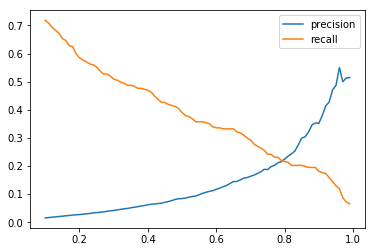

In [304]:
p=[]
r=[]
ts=[]

thresholds=np.arange(0.10, 1.00, 0.01)

y_true=y_test

for thres in thresholds:
    y_pred=predictions.iloc[:,1].apply(lambda x: 1 if x>=thres else 0 )
    p1=precision_score(y_true=y_true, y_pred=y_pred, average=None)
    r1=recall_score(y_true=y_true, y_pred=y_pred, average=None)
    
    
    p.append(p1[1])
    r.append(r1[1])
    ts.append(thres)

plt.plot(ts,p,label='precision')    
plt.plot(ts,r,label='recall')    
plt.legend(loc='upper right')    

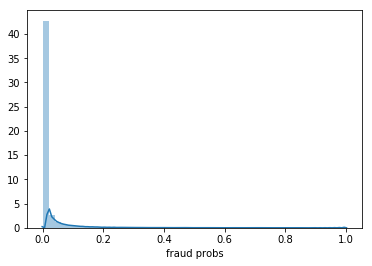

In [312]:
x = pd.Series(predictions.iloc[:,1], name="fraud probs")
sns.distplot(x)